In [55]:
import matplotlib.pyplot as plt
import numpy as np
import casperfpga
import time
from lwa_f import snap2_fengine
from lwa_f import blocks
#from lwautils import lwa_arx 
import pandas as pd
from cr_functions import *
import struct
import math
from scipy import special as sp
from scipy import optimize as oz
from scipy import stats as st
from lwa_antpos import mapping
import os

In [56]:
#filenames to save

fnameout='/home/ubuntu/kp/data/2024February20/nighttime-coincident_trigger_threshold_scan.npy'
fnamec='/home/ubuntu/kp/data/2024February20/nighttime-individual-antenna-scans-c.npy'
fnamev='/home/ubuntu/kp/data/2024February20/nighttime-individual-antenna-scans-v.npy'



In [57]:
brdnames=['snap01','snap02','snap03','snap04','snap05','snap06','snap07','snap08','snap09','snap10','snap11']
#casperbrds = [casperfpga.CasperFpga(brdname, transport=casperfpga.TapcpTransport) for brdname in brdnames]
casperbrds = [snap2_fengine.Snap2FengineEtcd(brdname).fpga for brdname in brdnames]

#this is not actually the file but it has the necessary info for the ethernet block
fpgfile='/home/ubuntu/kp/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c.fpg'



2024-02-23 05:18:07,812 - lwa_f.blocks.block:snap01 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-02-23 05:18:07,861 - lwa_f.blocks.block:snap02 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-02-23 05:18:07,865 - lwa_f.blocks.block:snap03 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-02-23 05:18:07,870 - lwa_f.blocks.block:snap04 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-02-23 05:18:07,875 - lwa_f.blocks.block:snap05 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-02-23 05:18:07,880 - lwa_f.blocks.block:snap06 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-02-23 05:18:07,885 - lwa_f.blocks.block:snap07 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-02-23 05:18:07,889 - lwa_f.blocks.block:snap08 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-02-23 05:18:07,894 - lwa_f.blocks.block:snap09 - INFO - eth - Couldn't find Ethernet core. 

In [63]:
casperbrds[0].listdev()


['aaa_onegbe_one_GbE',
 'adc_sync',
 'ads5296_controller0_0',
 'ads5296_controller0_1',
 'ads5296_controller1_0',
 'ads5296_controller1_1',
 'ads5296_hardware_rst0',
 'ads5296_hardware_rst1',
 'ads5296_spi_controller0',
 'ads5296_spi_controller1',
 'ads5296_wb_ram0_0_0',
 'ads5296_wb_ram0_0_1',
 'ads5296_wb_ram0_0_2',
 'ads5296_wb_ram0_0_3',
 'ads5296_wb_ram0_1_0',
 'ads5296_wb_ram0_1_1',
 'ads5296_wb_ram0_1_2',
 'ads5296_wb_ram0_1_3',
 'ads5296_wb_ram1_0_0',
 'ads5296_wb_ram1_0_1',
 'ads5296_wb_ram1_0_2',
 'ads5296_wb_ram1_0_3',
 'ads5296_wb_ram1_1_0',
 'ads5296_wb_ram1_1_1',
 'ads5296_wb_ram1_1_2',
 'ads5296_wb_ram1_1_3',
 'autocorr_acc_cnt',
 'autocorr_acc_len',
 'autocorr_common_dout0_bram',
 'autocorr_common_dout1_bram',
 'autocorr_common_dout2_bram',
 'autocorr_common_dout3_bram',
 'autocorr_common_dout4_bram',
 'autocorr_common_dout5_bram',
 'autocorr_common_dout6_bram',
 'autocorr_common_dout7_bram',
 'autocorr_mux_sel',
 'autocorr_trig',
 'chan_reorder_dynamic_map1',
 'corr_0_

In [67]:
print(casperbrds[0].read_int('cosmic_ray_veto_antennas1'))
casperbrds[0].write_int('cosmic_ray_veto_antennas1',2**32-1)
print(casperbrds[0].read_int('cosmic_ray_veto_antennas1'))


8
-1


## Single-antenna threshold scans

In [ ]:
thresholds = 8*np.asarray(range(64))
vthresholds = np.flip(thresholds)
results_core = np.zeros((64,64,11))
results_veto = np.zeros((64,64,11))

[setup_data_source(casperbrd,"adc") for casperbrd in casperbrds]


for i in range(len(thresholds)):
    t_c = thresholds[i]
    t_v = vthresholds[i]
    [setvalue(casperbrd,"trigger_power_thresh","cr_registers.xlsx",int(t_c**2)) for casperbrd in casperbrds]
    [setvalue(casperbrd,"veto_power_thresh","cr_registers.xlsx",int(t_v**2)) for casperbrd in casperbrds]
    time.sleep(2.75)  #have to wait for it to update
    
    #read results for this threshold
    for b, casperbrd in enumerate(casperbrds):
        core,veto = read_threshold_rates(casperbrd)
        results_core[:,i,b] = core
        results_veto[:,i,b] = veto



### Debug

In [71]:
setvalue(casperbrds[0],'select_input_signal', 'cr_registers.xlsx', 3)

Failed to JSON-encode command
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/lwa_f/snap2_feng_etcd_client.py", line 113, in _format_command
    command_json = json.dumps(command_dict)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/__init__.py", line 231, in dumps
    return _default_encoder.encode(obj)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/encoder.py", line 199, in encode
    chunks = self.iterencode(o, _one_shot=True)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/encoder.py", line 257, in iterencode
    return _iterencode(o, 0)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/encoder.py", line 180, in default
    o.__class__.__name__)
TypeError: Object of type 'int64' is not JSON serializable
Failed to JSON-encode command
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/lwa_f/snap2_feng_etcd_client.py", line 113, in

Failed to JSON-encode command
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/lwa_f/snap2_feng_etcd_client.py", line 113, in _format_command
    command_json = json.dumps(command_dict)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/__init__.py", line 231, in dumps
    return _default_encoder.encode(obj)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/encoder.py", line 199, in encode
    chunks = self.iterencode(o, _one_shot=True)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/encoder.py", line 257, in iterencode
    return _iterencode(o, 0)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/encoder.py", line 180, in default
    o.__class__.__name__)
TypeError: Object of type 'int64' is not JSON serializable


TypeError: Object of type 'int64' is not JSON serializable

In [ ]:
def setvalue(brd,name,fname,newvalue):
    #brd is a casperfpga CasperFpga object
    #fname is the file name of the register description table
    #name is the name of the setting you want to update on the board
    #newvalue is the new value you want to update that setting with
    mainregistername=info['registername'].values[0]
    mainregistervalue=brd.read_int(mainregistername)

In [74]:
brd=casperbrds[0]
name='select_input_signal'
fname='cr_registers.xlsx'
newvalue=3


info=lookup_register(name,fname)
mainregistername=info['registername'].values[0]
mainregistervalue=brd.read_int(mainregistername)
updatedvalue=updatevalue(mainregistervalue,info['mainregister_bitwidth'].values[0],info['offset_from_msb'].values[0],info['bitwidth'].values[0],newvalue)


In [75]:
brd.write_int(mainregistername,updatedvalue)

Failed to JSON-encode command
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/lwa_f/snap2_feng_etcd_client.py", line 113, in _format_command
    command_json = json.dumps(command_dict)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/__init__.py", line 231, in dumps
    return _default_encoder.encode(obj)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/encoder.py", line 199, in encode
    chunks = self.iterencode(o, _one_shot=True)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/encoder.py", line 257, in iterencode
    return _iterencode(o, 0)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/encoder.py", line 180, in default
    o.__class__.__name__)
TypeError: Object of type 'int64' is not JSON serializable
Failed to JSON-encode command
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/lwa_f/snap2_feng_etcd_client.py", line 113, in

Failed to JSON-encode command
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/lwa_f/snap2_feng_etcd_client.py", line 113, in _format_command
    command_json = json.dumps(command_dict)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/__init__.py", line 231, in dumps
    return _default_encoder.encode(obj)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/encoder.py", line 199, in encode
    chunks = self.iterencode(o, _one_shot=True)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/encoder.py", line 257, in iterencode
    return _iterencode(o, 0)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/encoder.py", line 180, in default
    o.__class__.__name__)
TypeError: Object of type 'int64' is not JSON serializable


TypeError: Object of type 'int64' is not JSON serializable

In [77]:
print(updatedvalue.dtype)
print(mainregistervalue.dtype)

int64


AttributeError: 'int' object has no attribute 'dtype'

In [ ]:
def updatevalue(mainregister,nbits,MSBoffset,bw,newval):
    #update the value of the specified consecutive bits of mainregister
    #MSBoffset is the offset from the most significant bit of mainregister
    #bw is the bitwidth of the number to extract
    #nbits is the number of bits of mainregister
    #newval is the new value to write to that subset of bits
    #returns updated value of mainregister
    LSBoffset=nbits-(MSBoffset+bw)
    extractmask = ((1<<bw) - 1) <<LSBoffset
    excludemask = ((1<<nbits)-1) - extractmask
    mainregister=(mainregister&excludemask) + (newval<<LSBoffset)
    return mainregister

In [ ]:
updatedvalue=updatevalue(,,,,newvalue)


In [78]:
mainregister=mainregistervalue
nbits=info['mainregister_bitwidth'].values[0]
MSBoffset=info['offset_from_msb'].values[0]
bw=info['bitwidth'].values[0]
newval=newvalue

In [79]:
LSBoffset=nbits-(MSBoffset+bw)
extractmask = ((1<<bw) - 1) <<LSBoffset
excludemask = ((1<<nbits)-1) - extractmask
mainregister=(mainregister&excludemask) + (newval<<LSBoffset)



In [84]:
print(mainregister.dtype)
print(excludemask.dtype)
print(extractmask.dtype)
print(((1<<nbits)-1).dtype)
print(LSBoffset.dtype)
print(nbits.dtype)
print(MSBoffset.dtype)
print(bw.dtype)
print(LSBoffset.dtype)

int64
int64
int64
int64
int64
int64
int64
int64
int64


In [85]:
mainregister=mainregistervalue
nbits=int(info['mainregister_bitwidth'].values[0])
MSBoffset=int(info['offset_from_msb'].values[0])
bw=int(info['bitwidth'].values[0])
newval=newvalue

In [86]:
LSBoffset=nbits-(MSBoffset+bw)
extractmask = ((1<<bw) - 1) <<LSBoffset
excludemask = ((1<<nbits)-1) - extractmask
mainregister=(mainregister&excludemask) + (newval<<LSBoffset)


In [96]:
#print(mainregister.dtype)
#print(excludemask.dtype)
#print(extractmask.dtype)
#print(((1<<nbits)-1).dtype)
#print(LSBoffset.dtype)
#print(nbits.dtype)
#print(MSBoffset.dtype)
#print(bw.dtype)
#print(LSBoffset.dtype)

In [82]:
a=1<<1
print(a)
print(a.dtype)


4


AttributeError: 'int' object has no attribute 'dtype'

In [ ]:
##############

In [45]:
np.save(fnamec,results_core)
np.save(fnamev,results_veto)

LWA-078A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<Figure size 432x288 with 0 Axes>

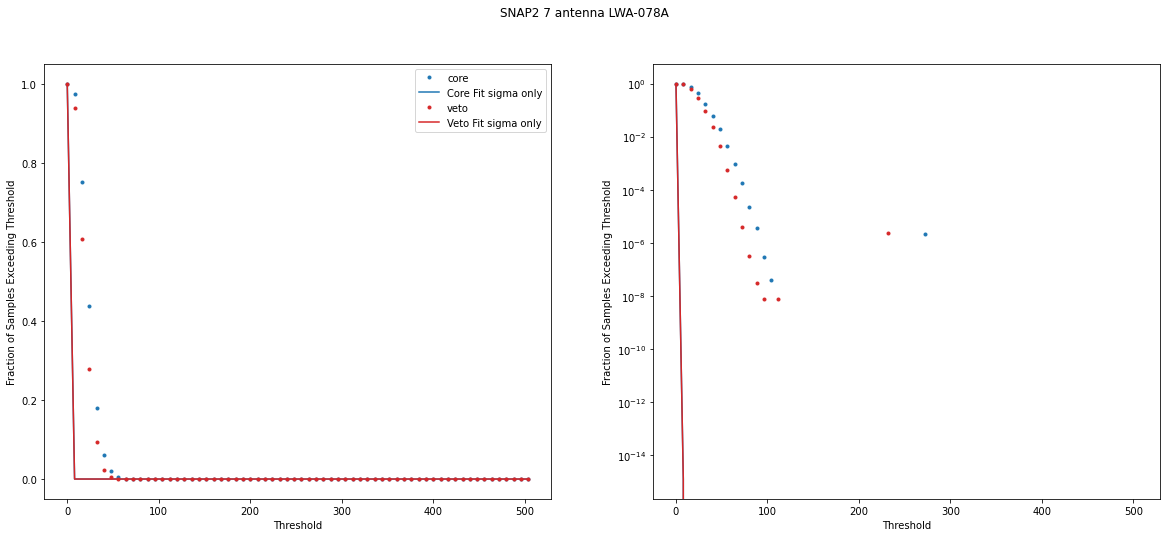

LWA-078B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


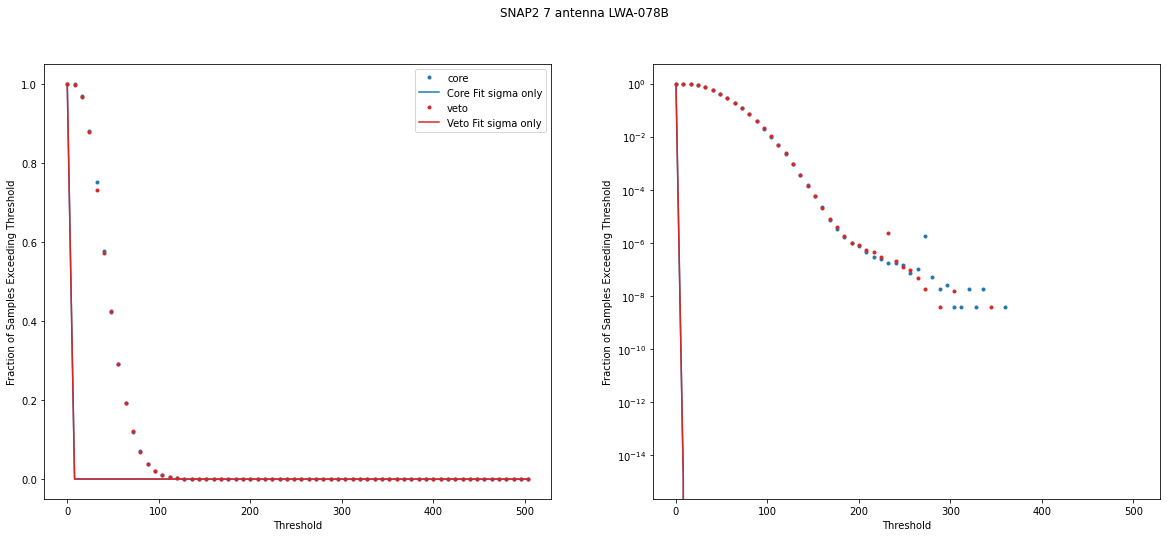

LWA-076A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


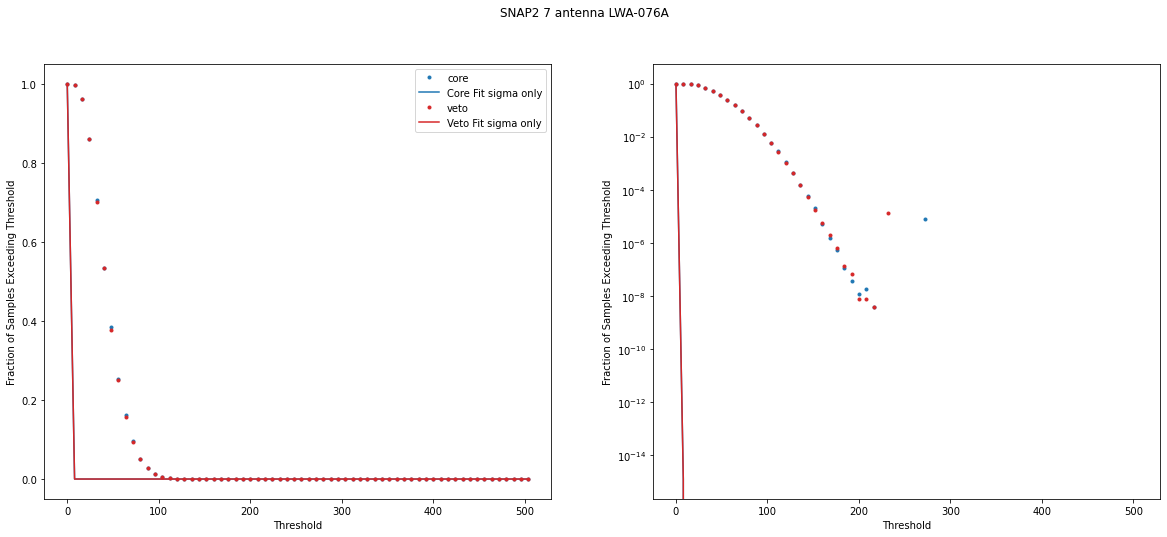

LWA-076B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


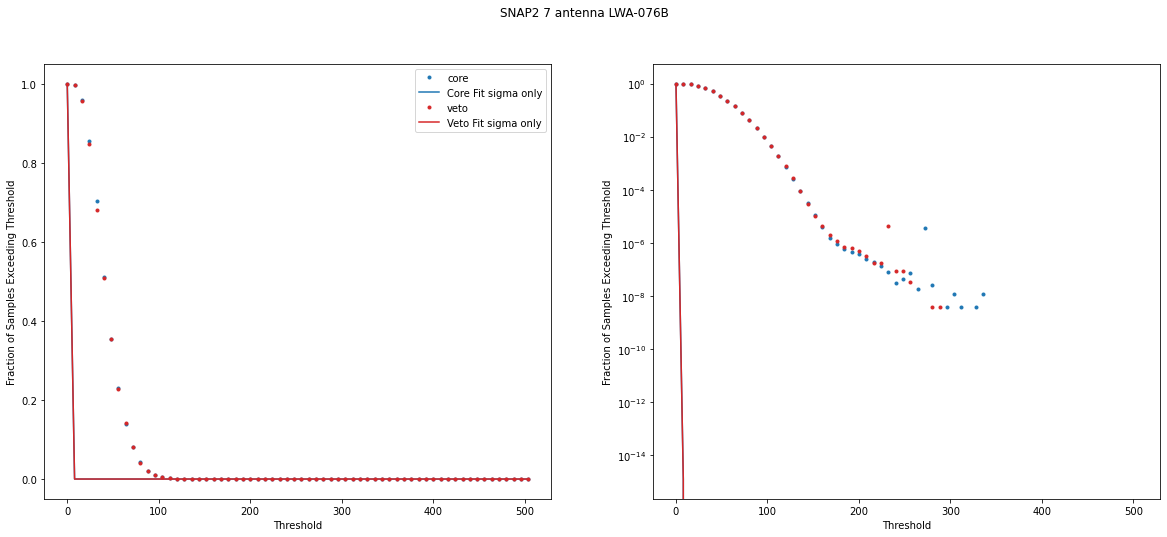

LWA-081A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


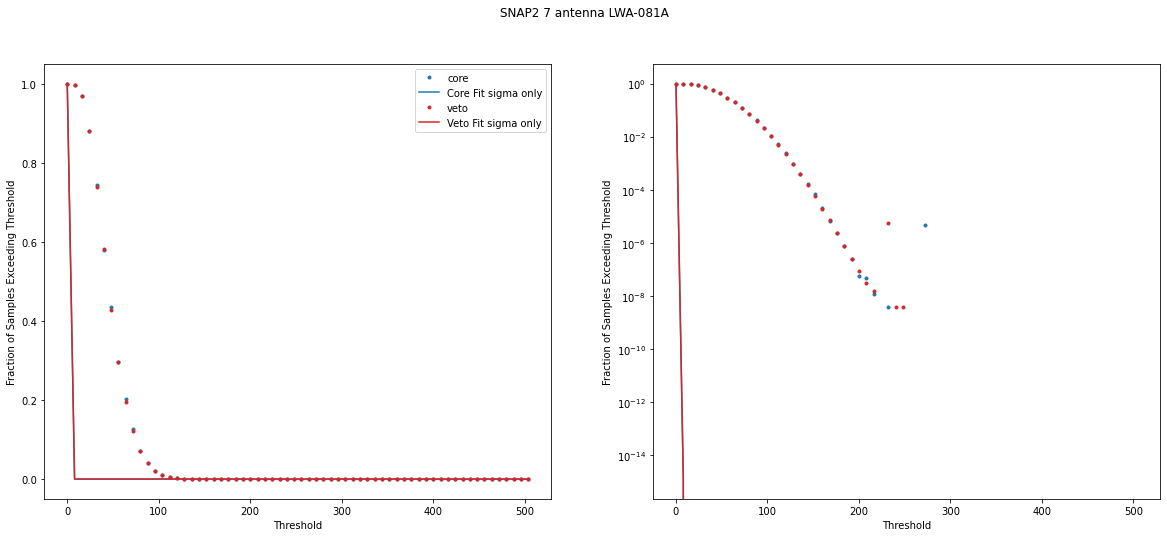

LWA-081B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


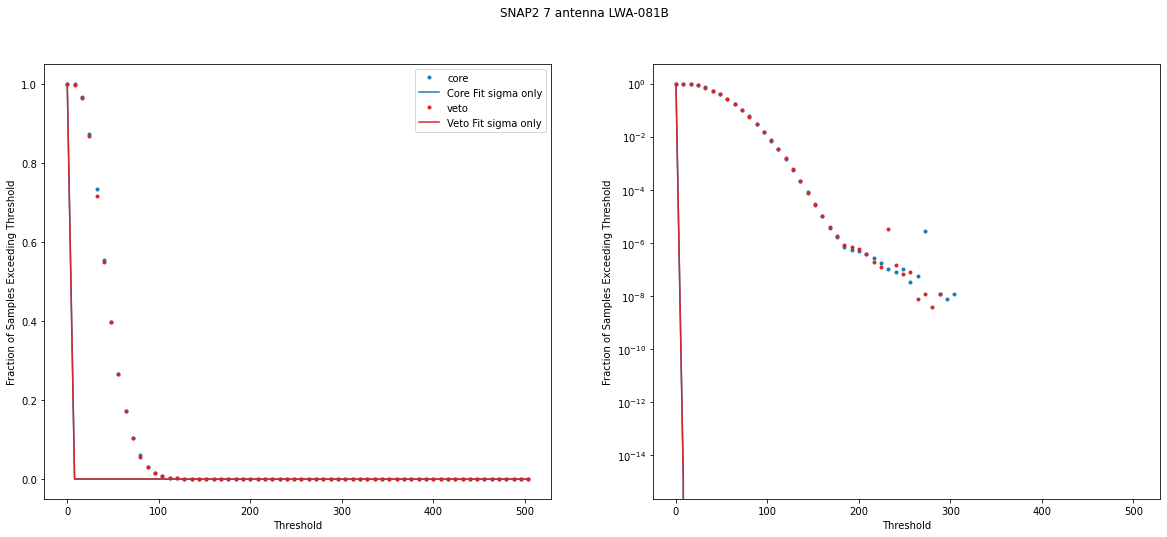

LWA-079A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


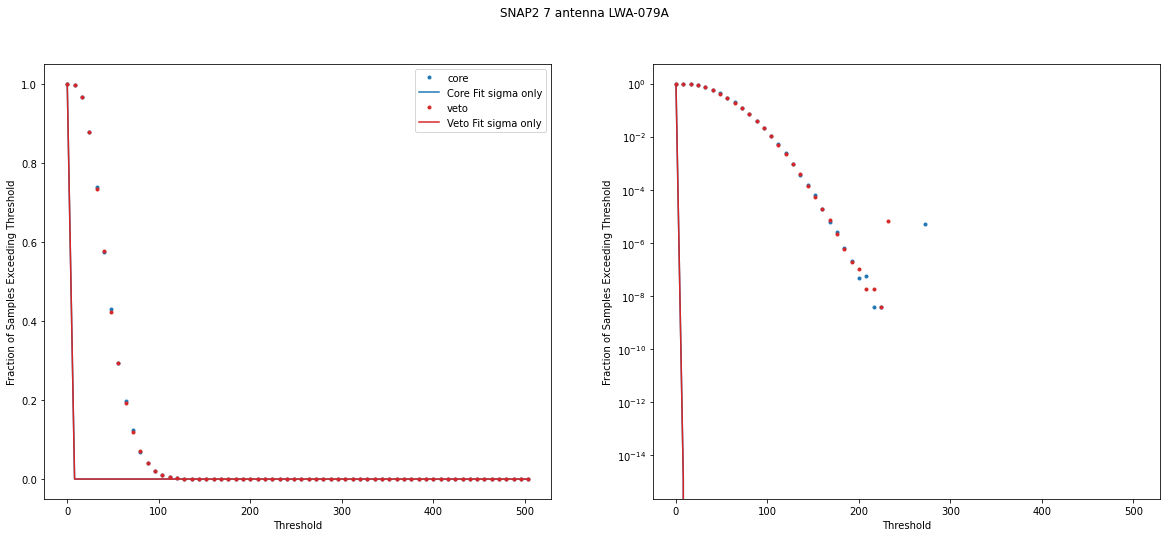

LWA-079B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


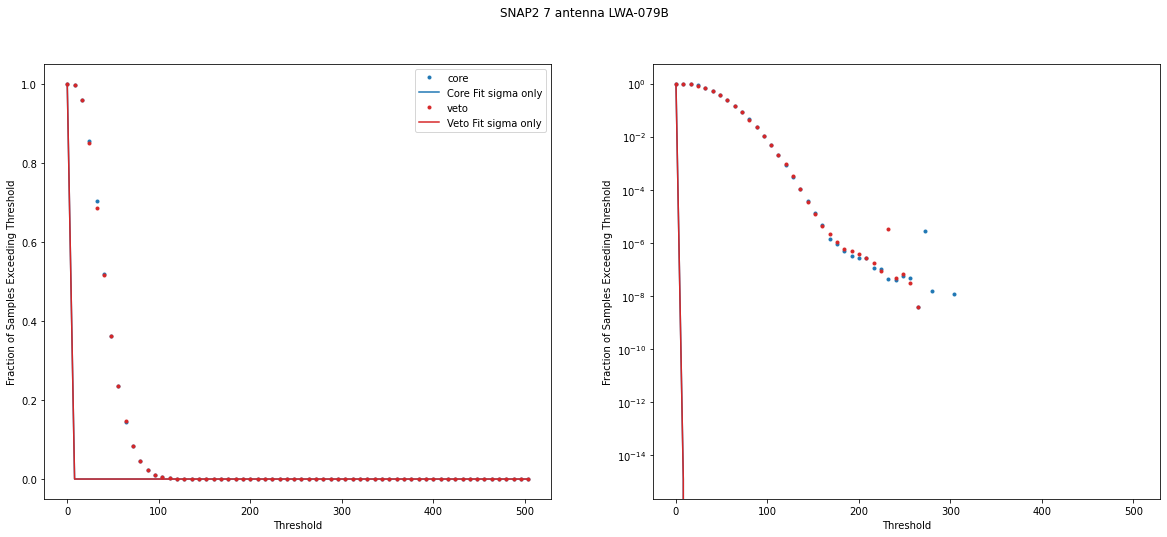

LWA-108A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


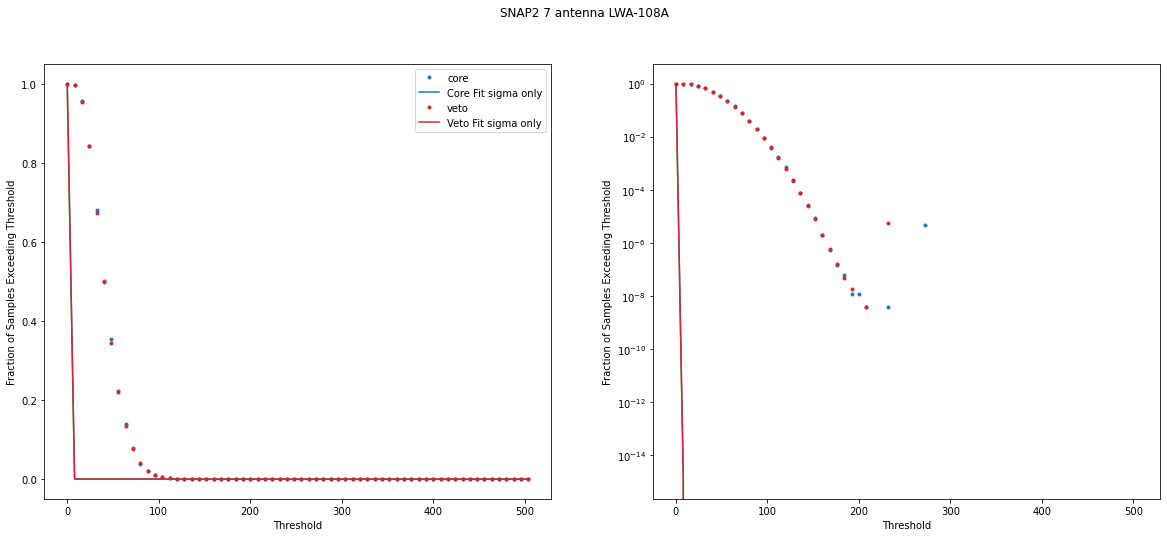

LWA-108B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


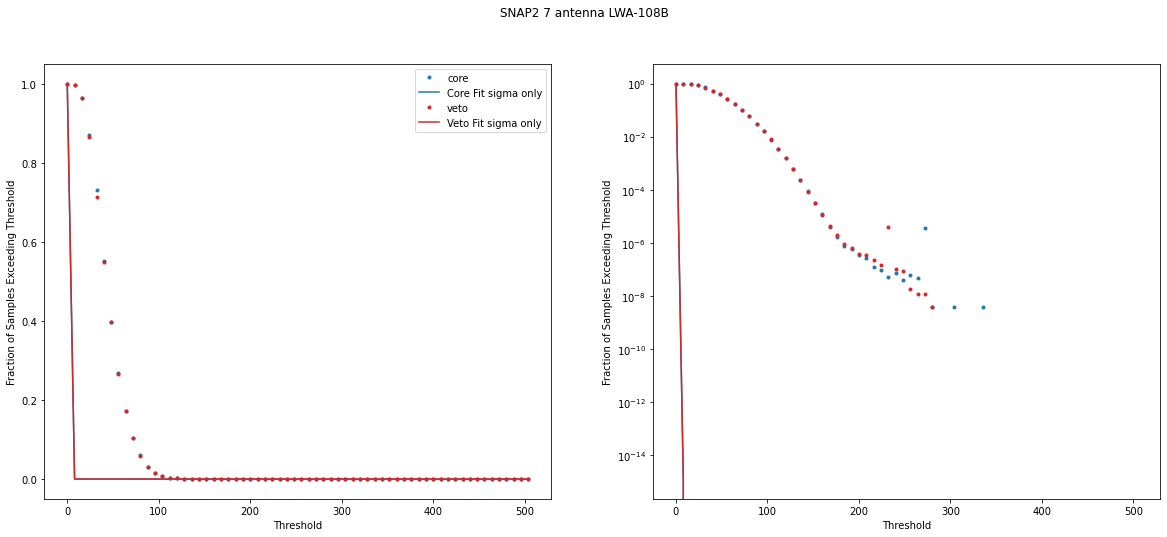

LWA-107A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


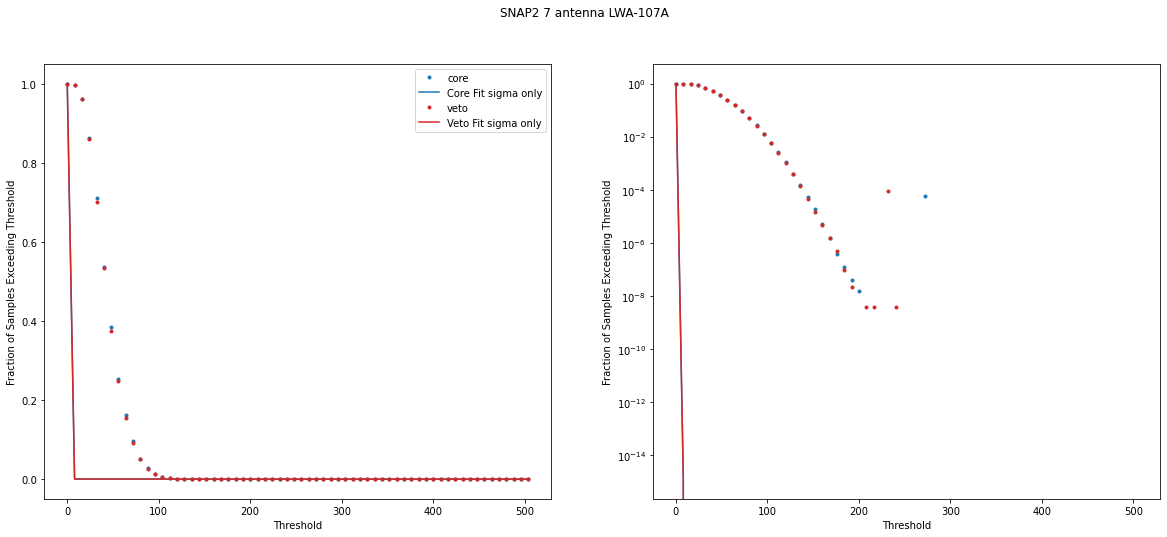

LWA-107B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


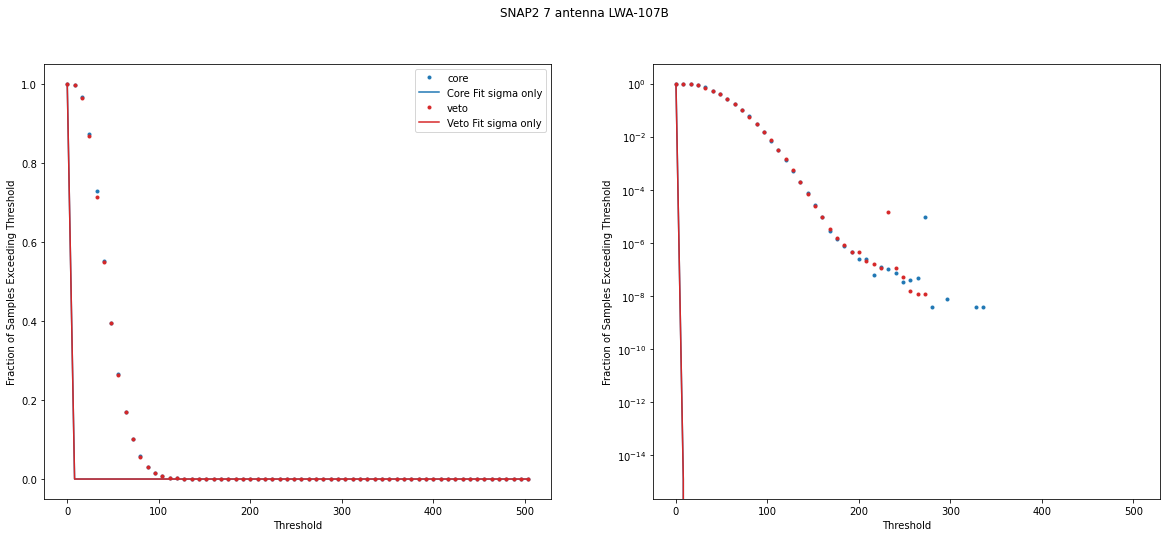

LWA-110A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


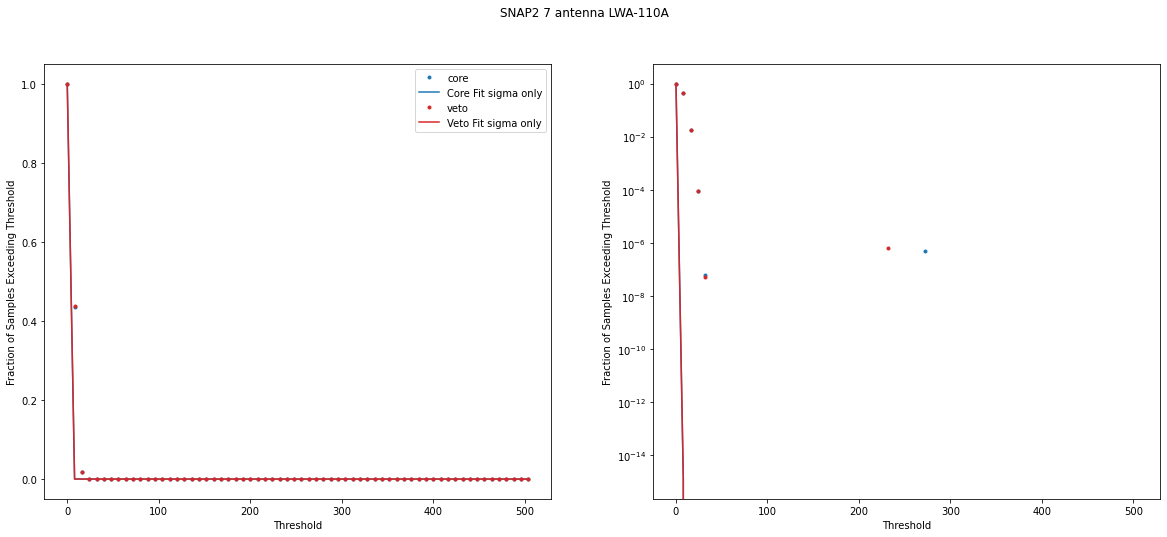

LWA-110B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


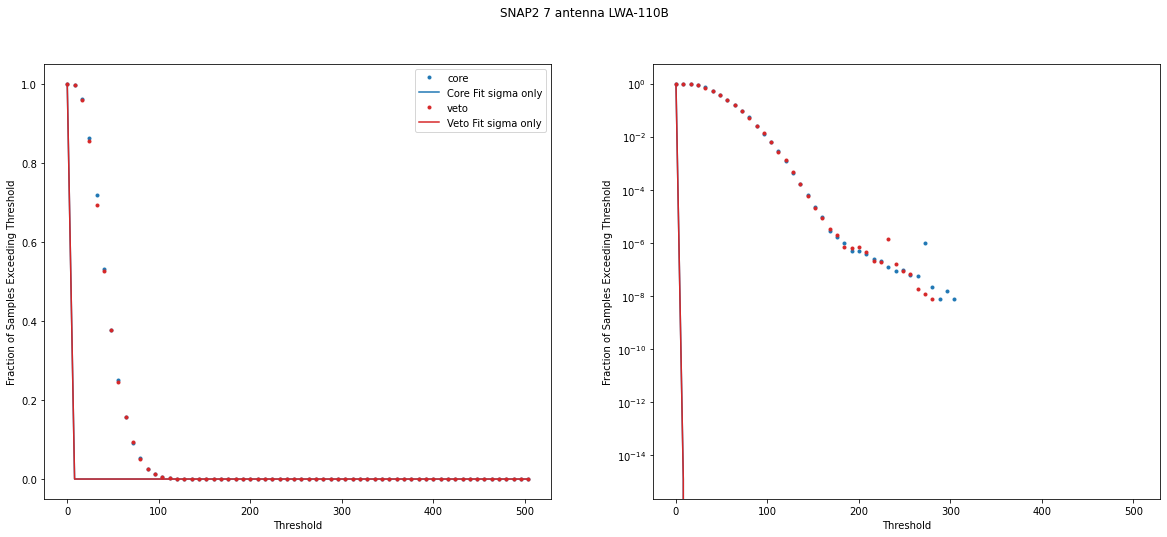

LWA-109A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


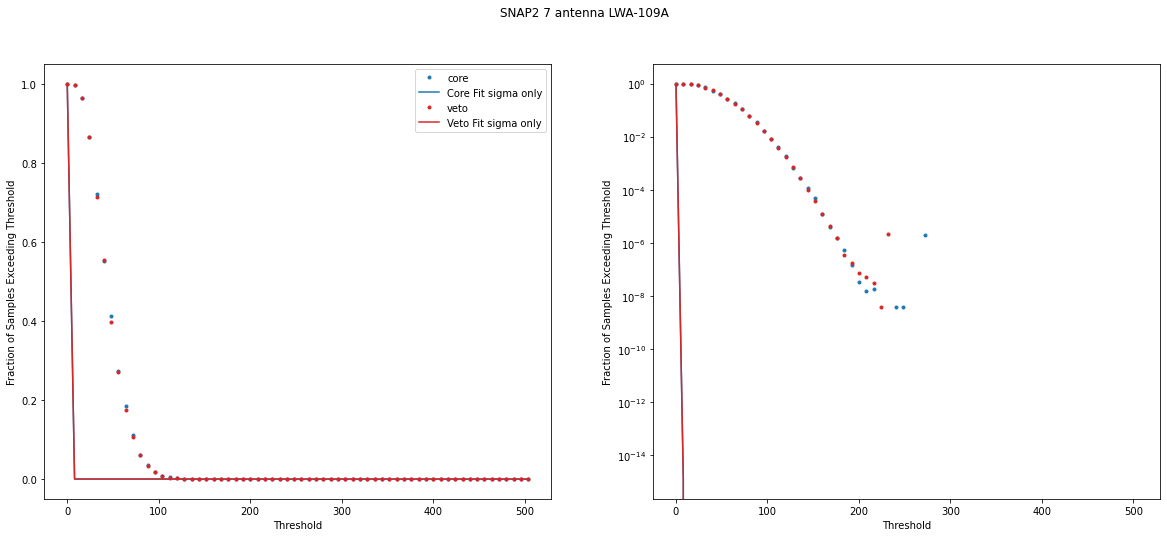

LWA-109B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


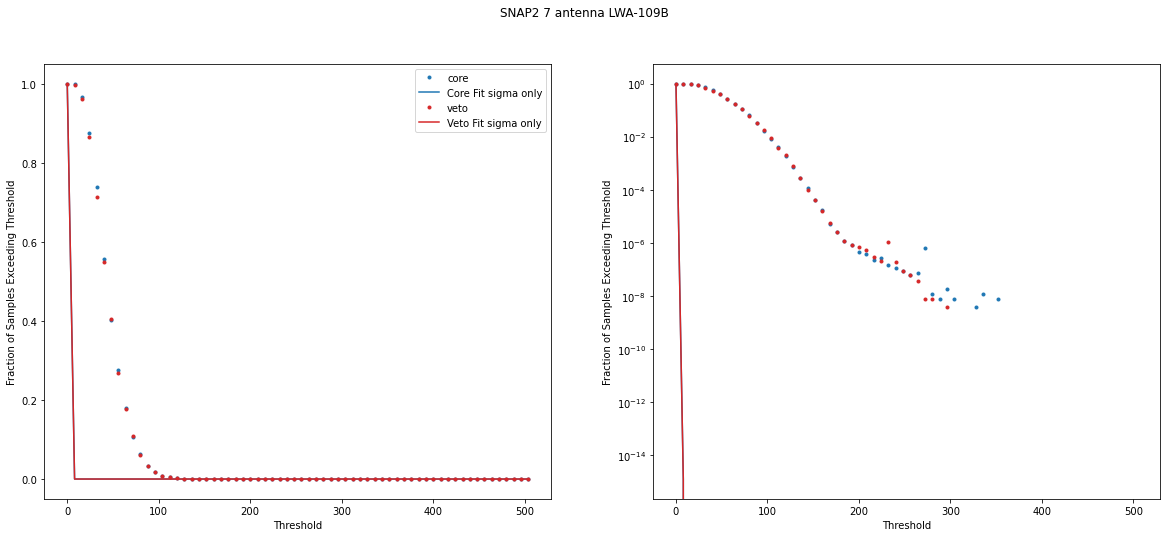

LWA-112A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


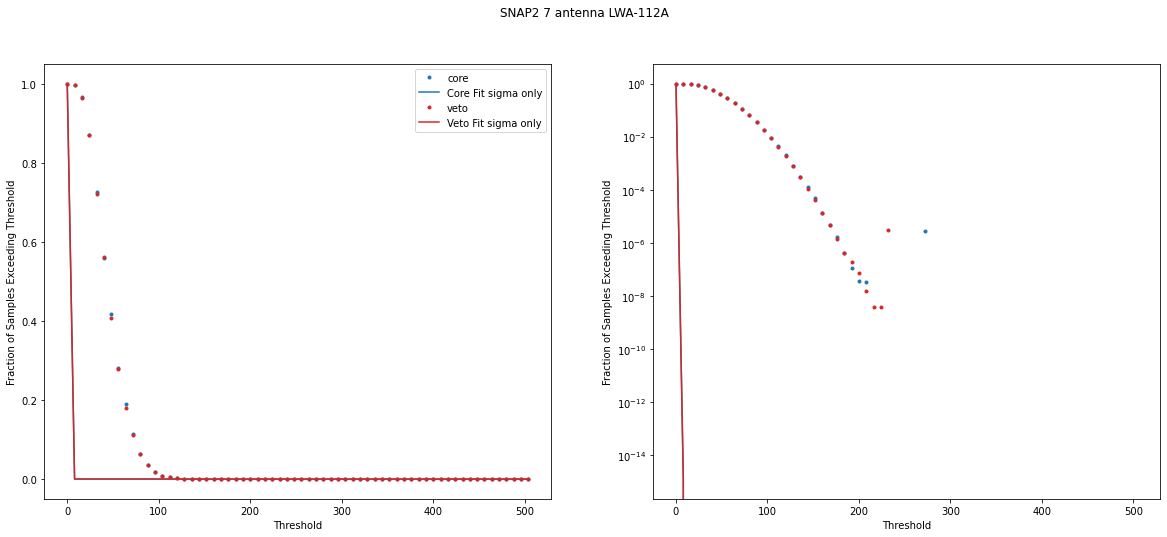

LWA-112B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


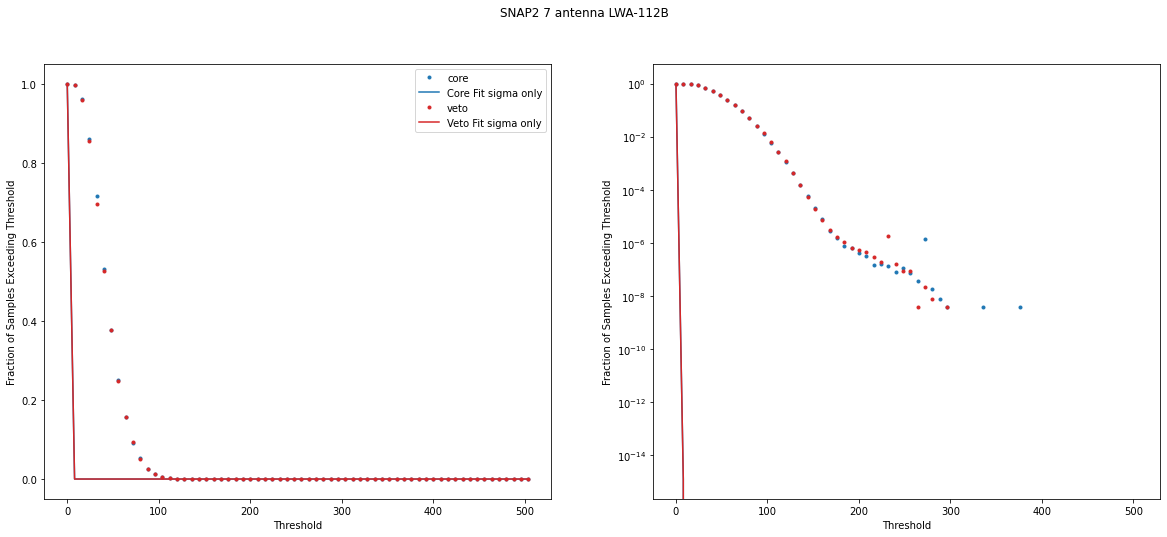

LWA-111A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


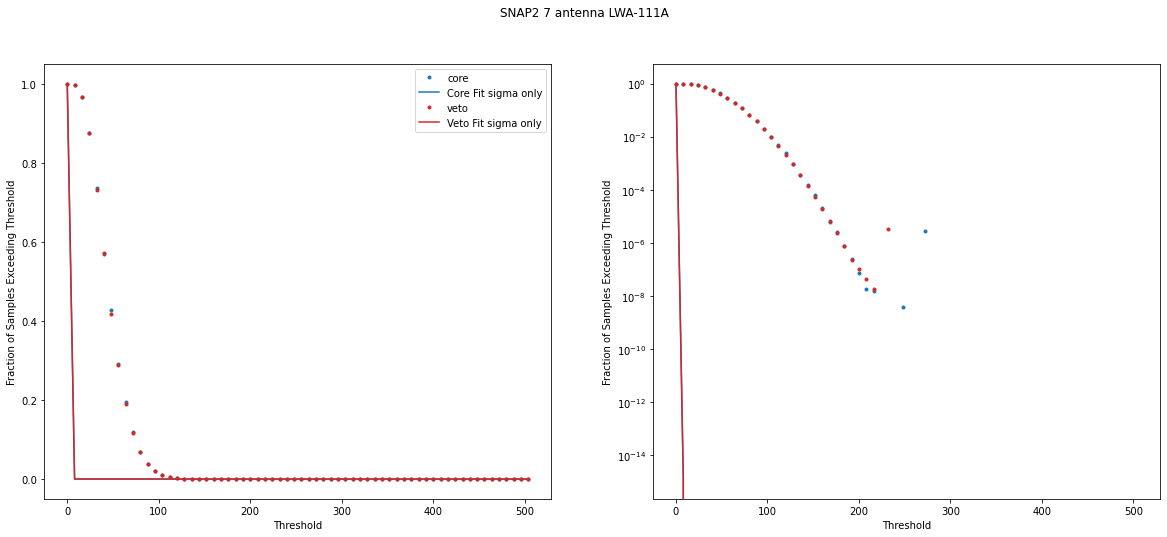

LWA-111B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


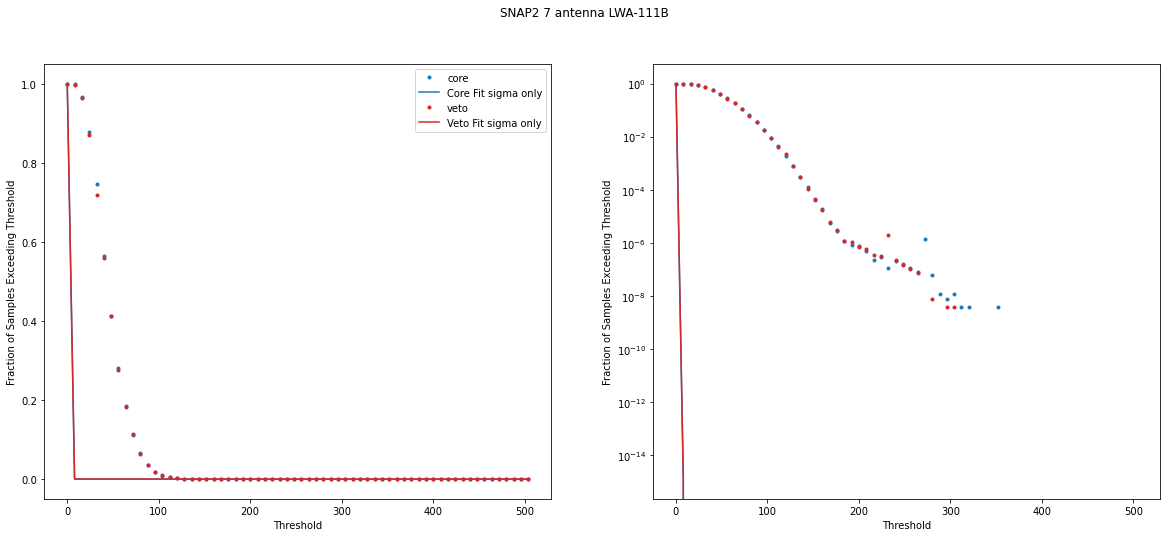

LWA-114A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


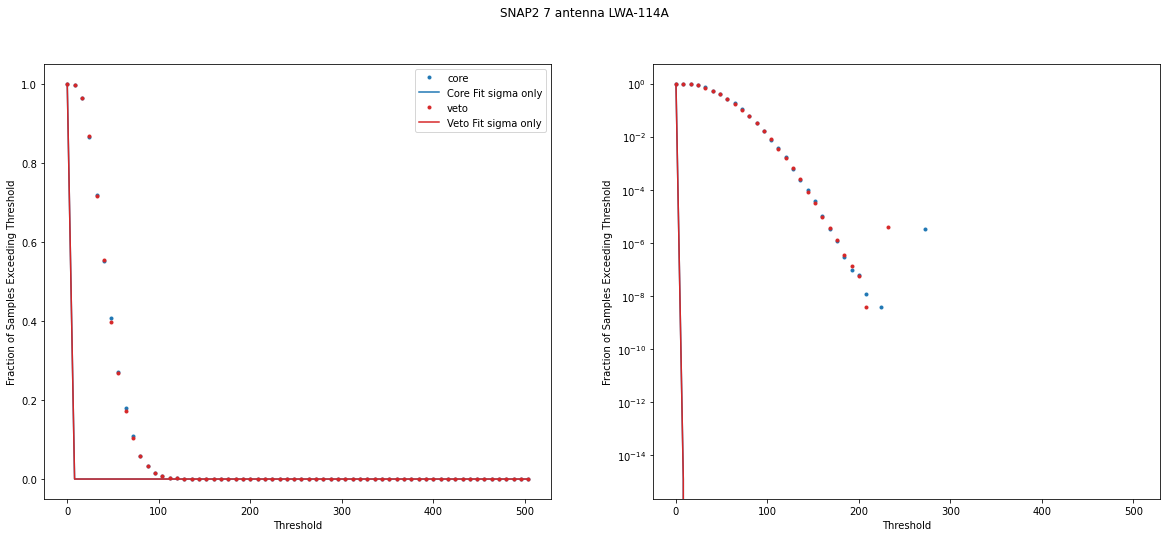

LWA-114B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


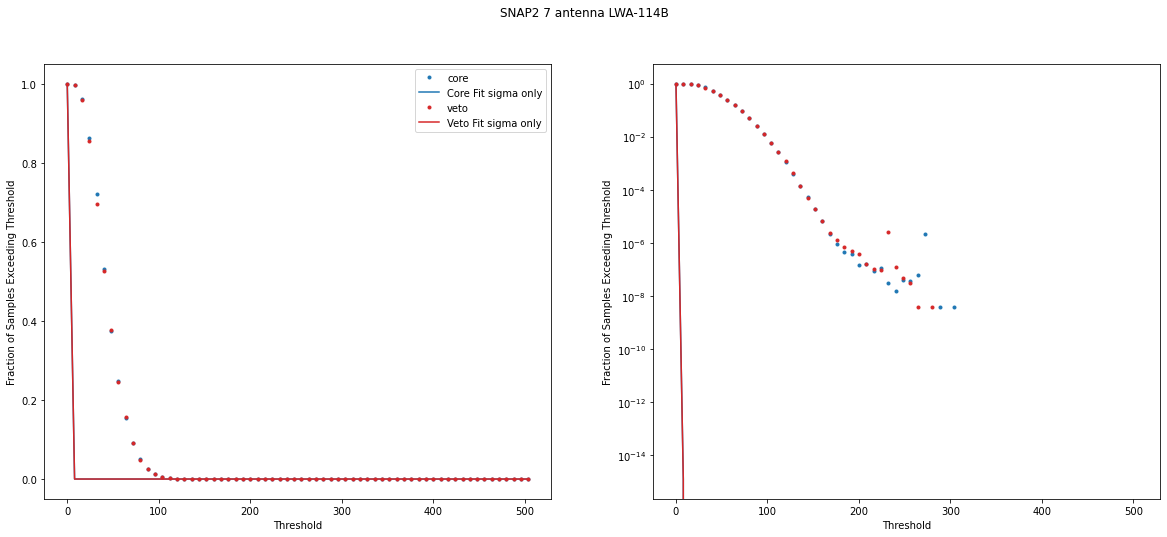

LWA-113A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


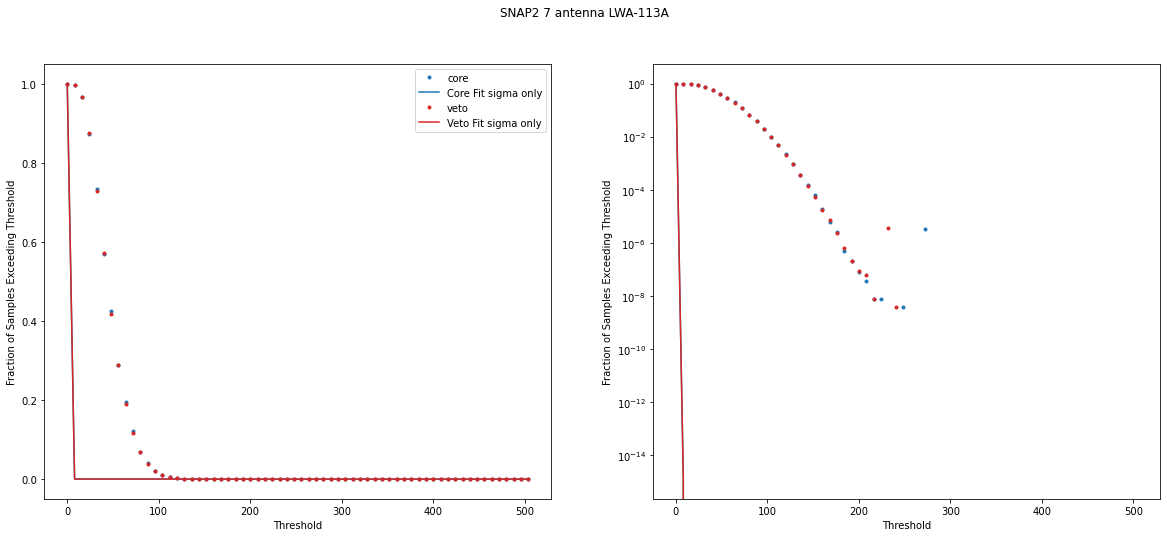

LWA-113B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


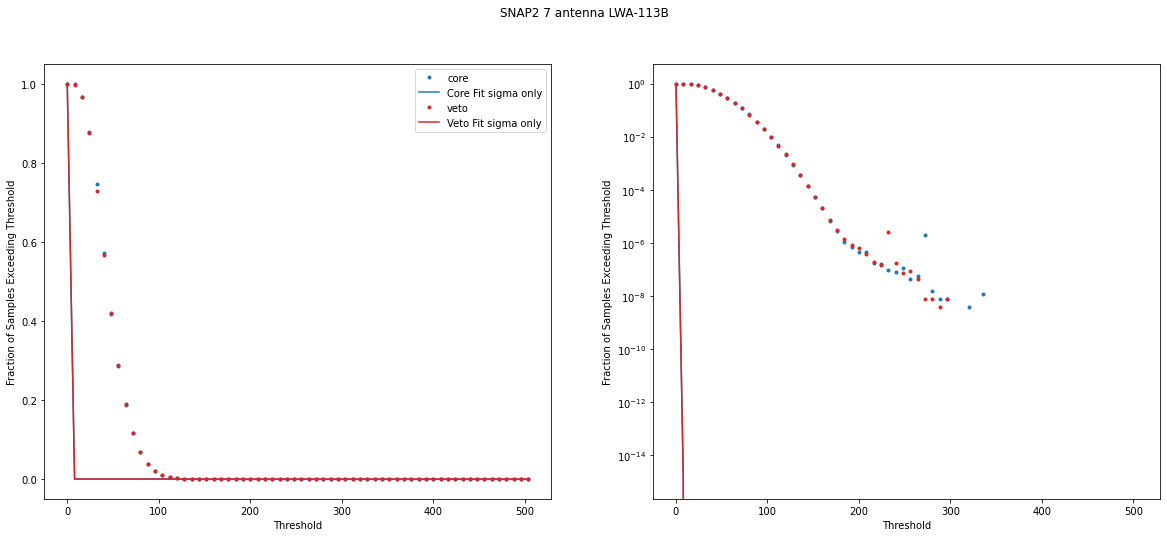

LWA-116A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


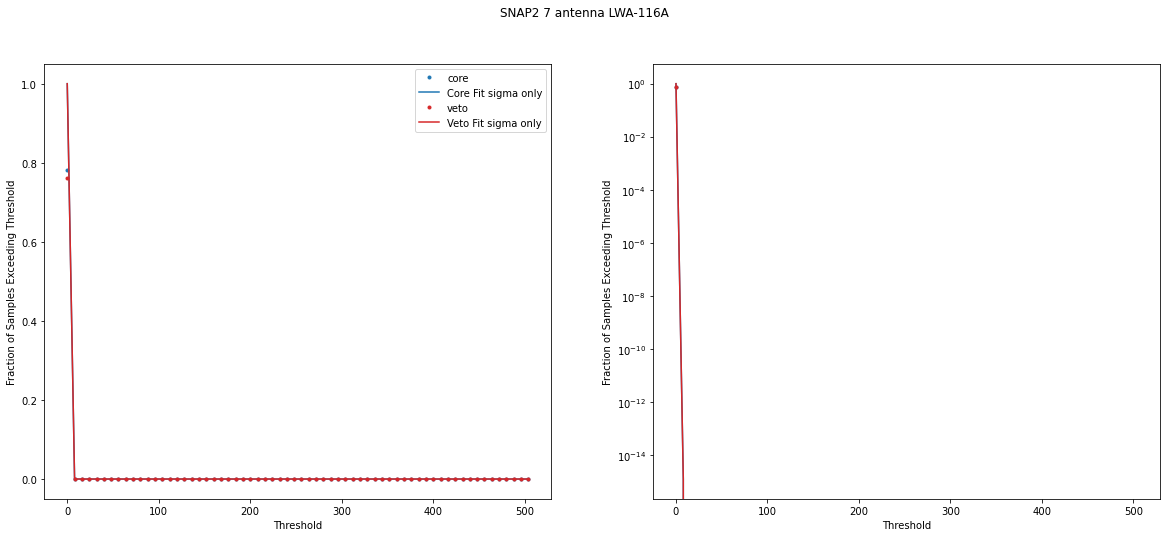

LWA-116B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


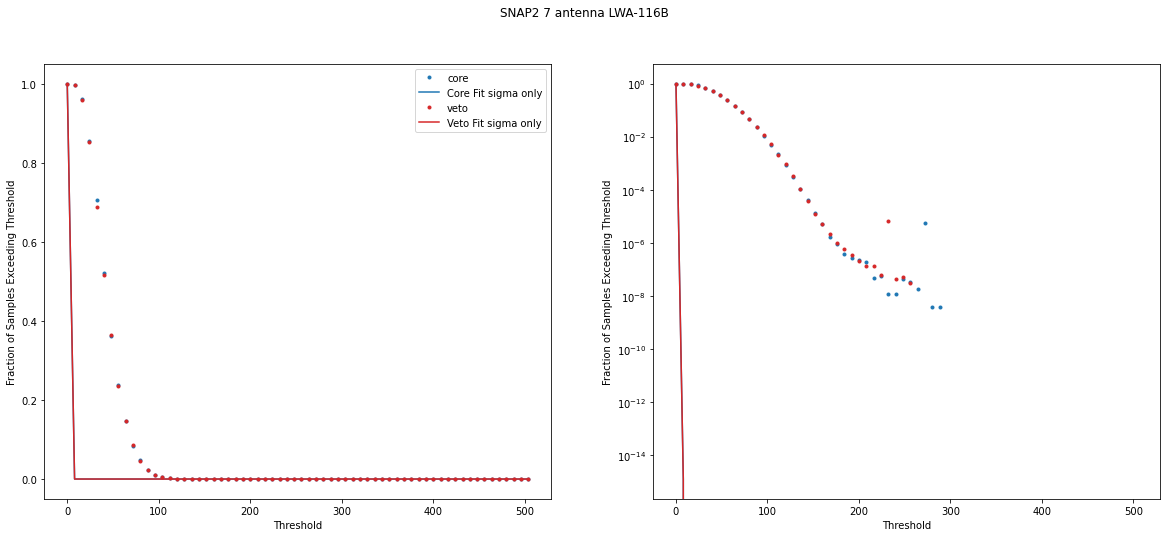

LWA-115A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


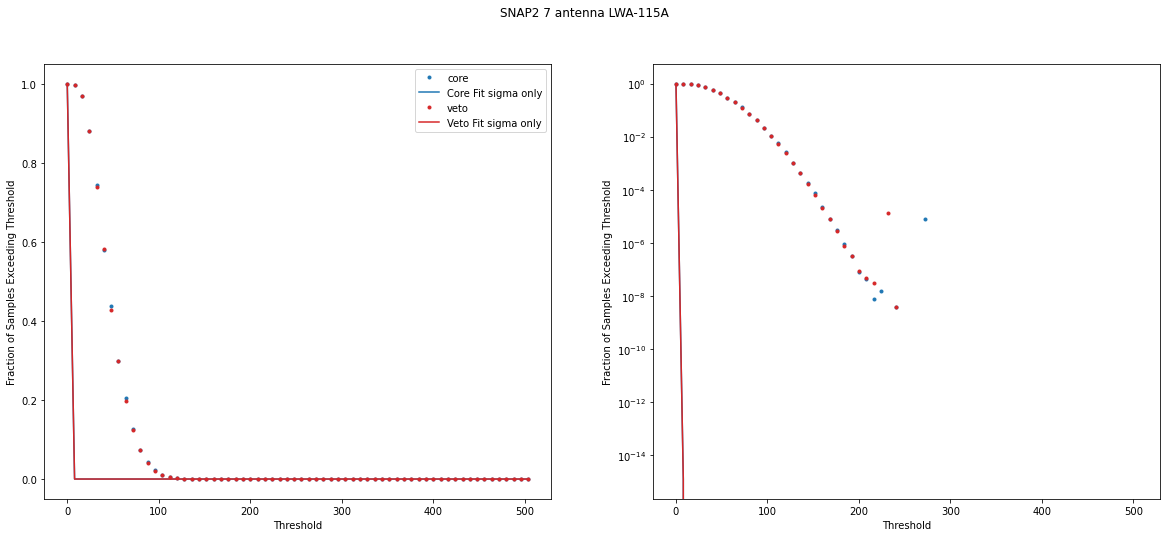

LWA-115B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


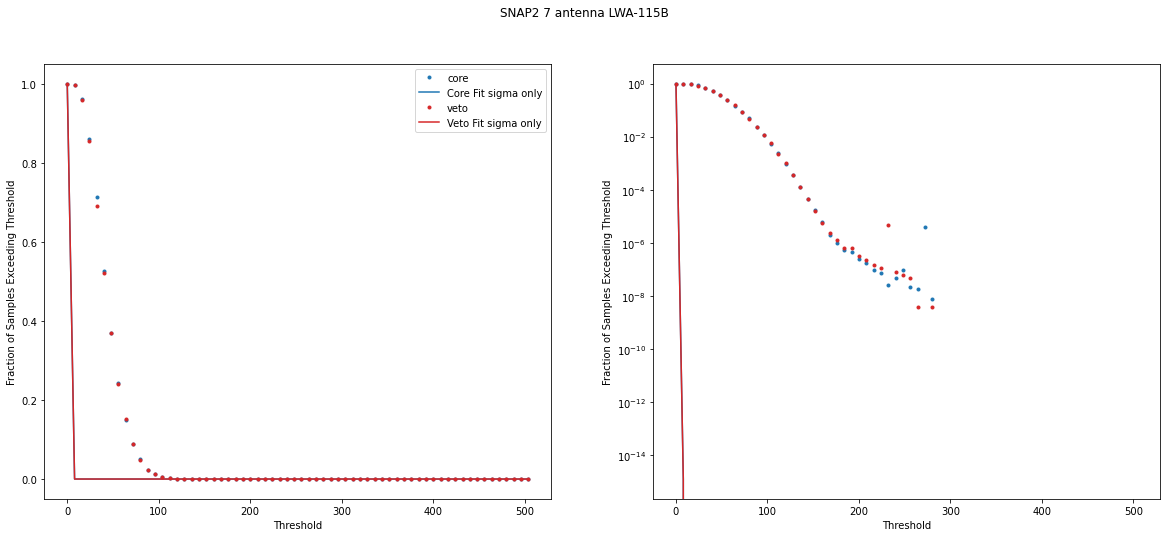

LWA-118A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


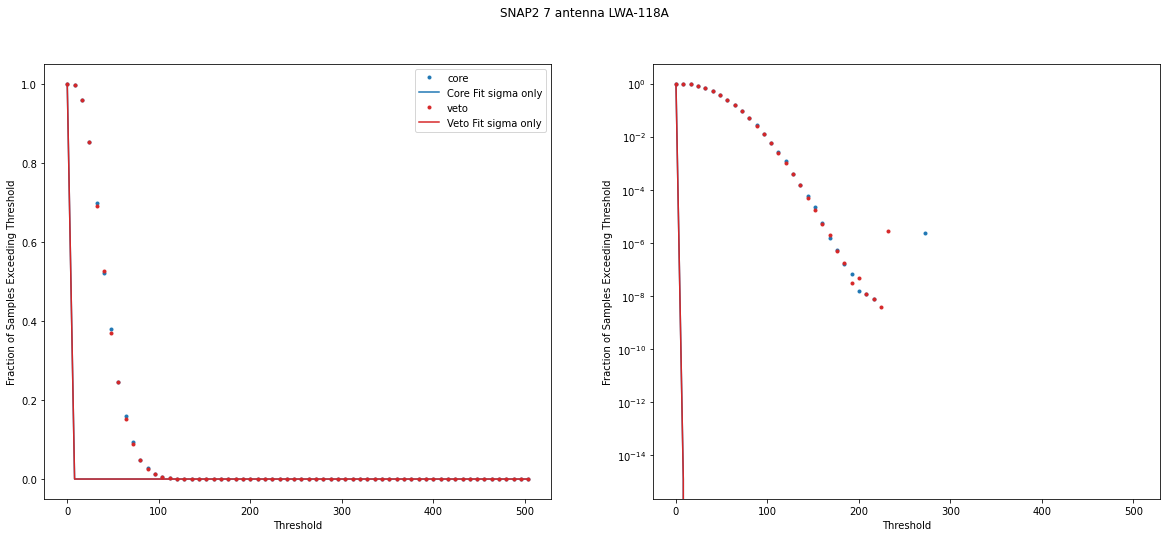

LWA-118B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


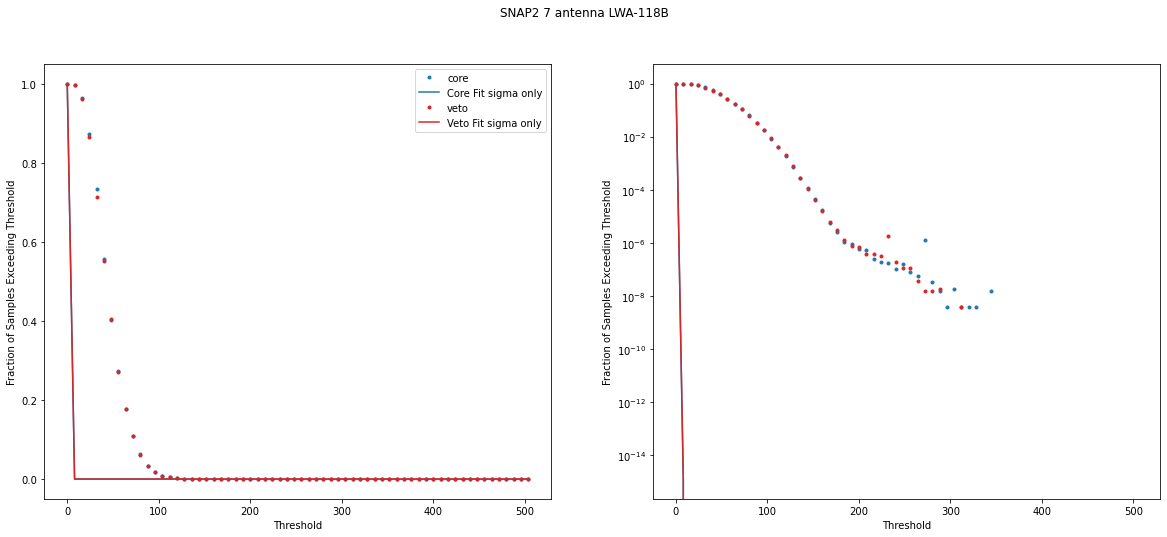

LWA-117A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


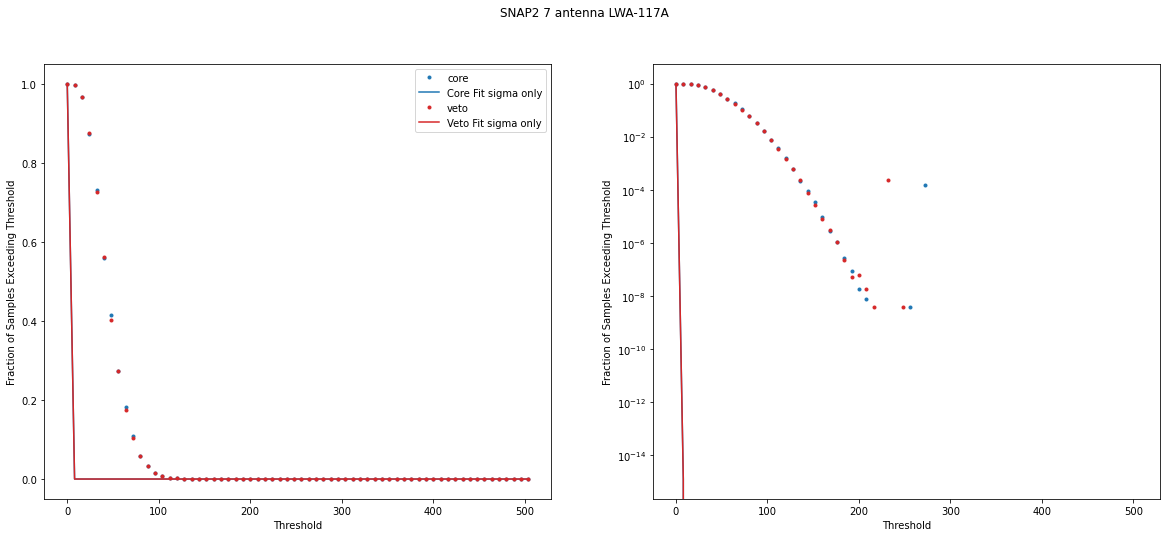

LWA-117B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


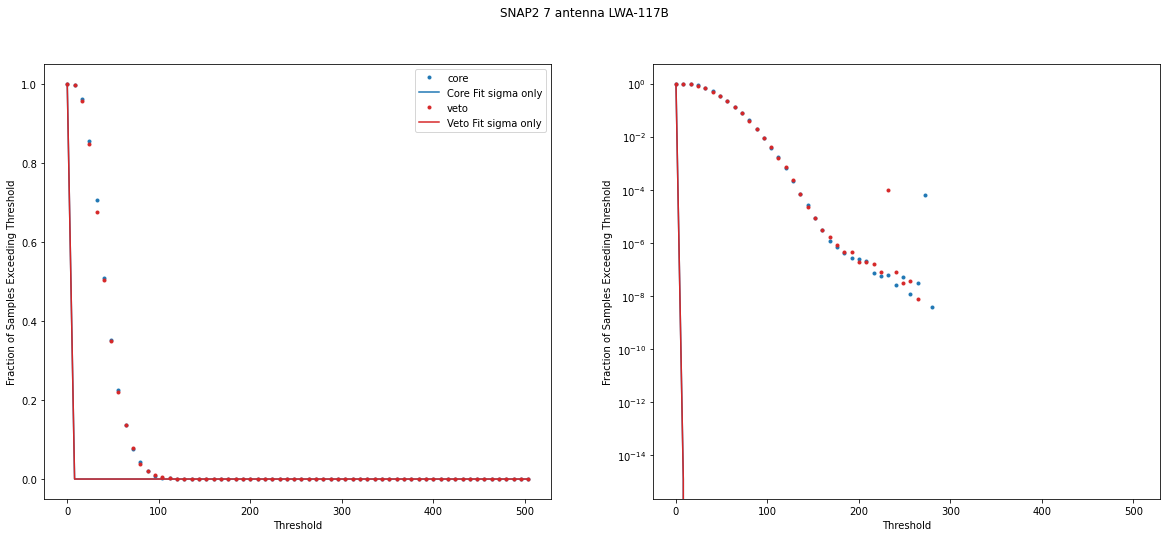

LWA-120A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


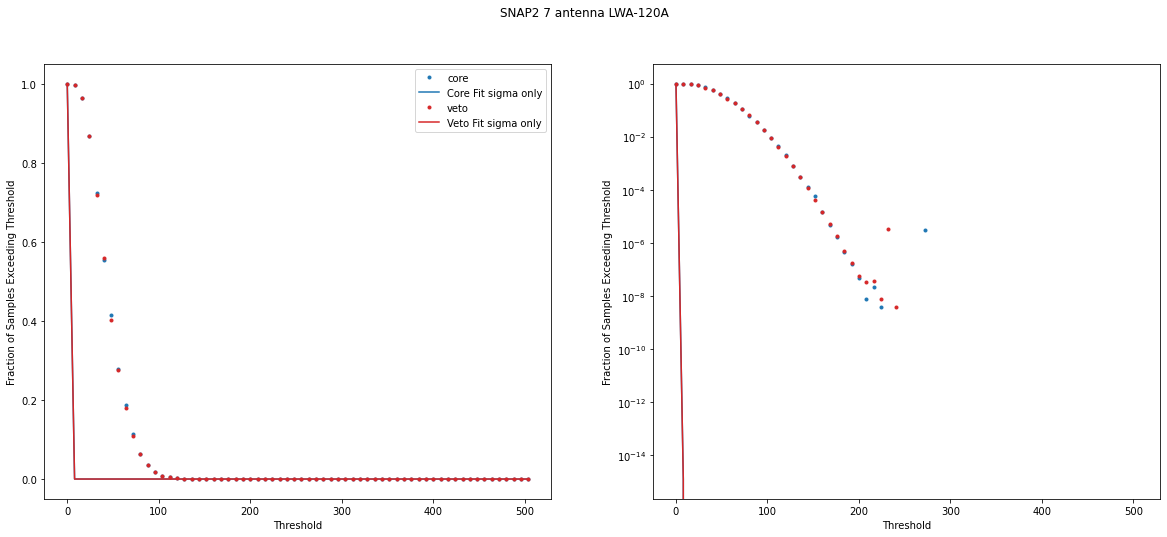

LWA-120B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


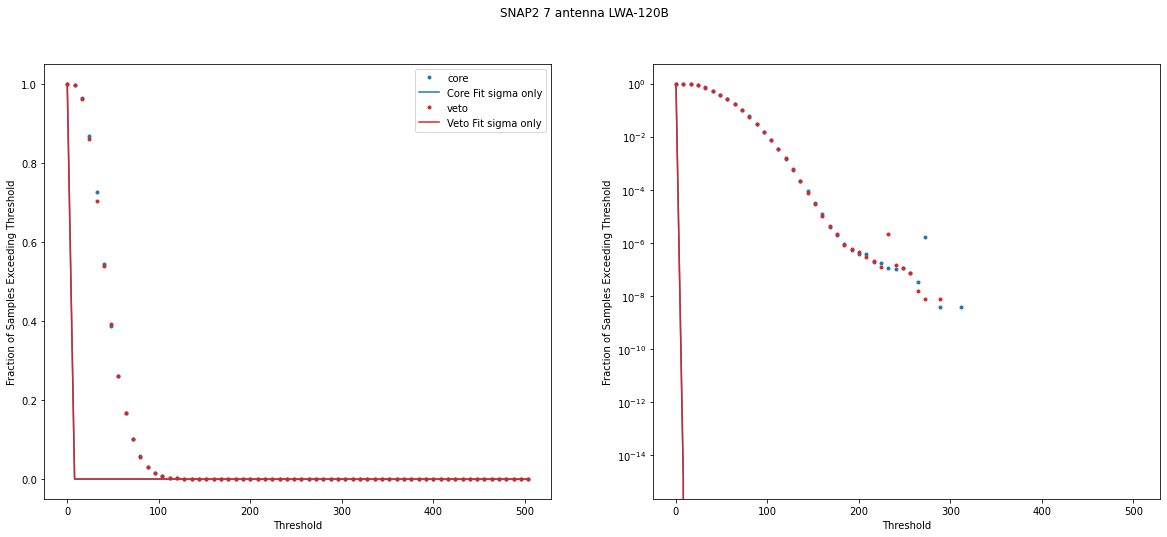

LWA-082A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


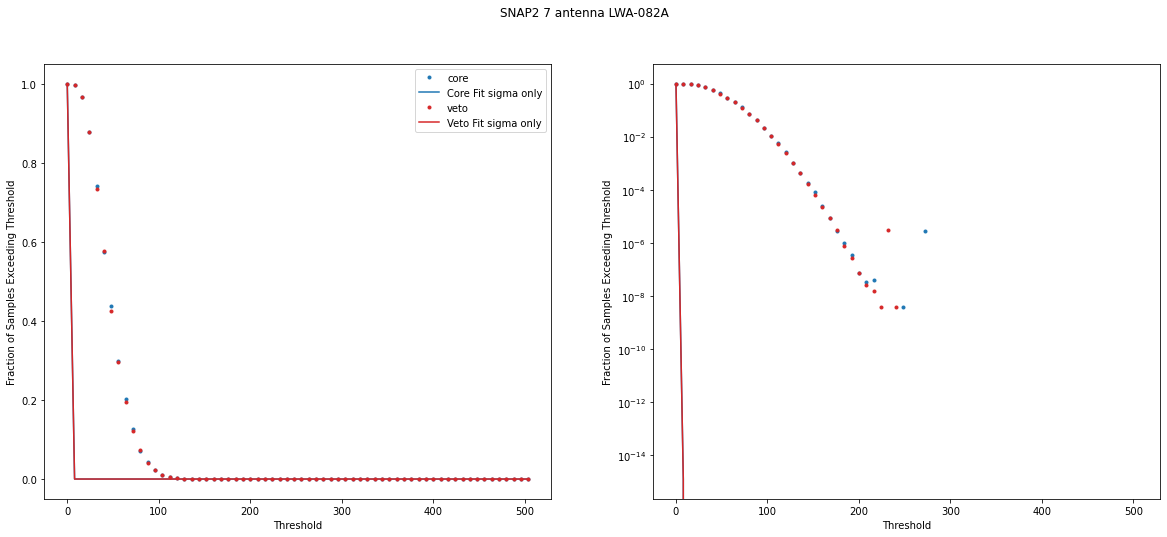

LWA-082B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


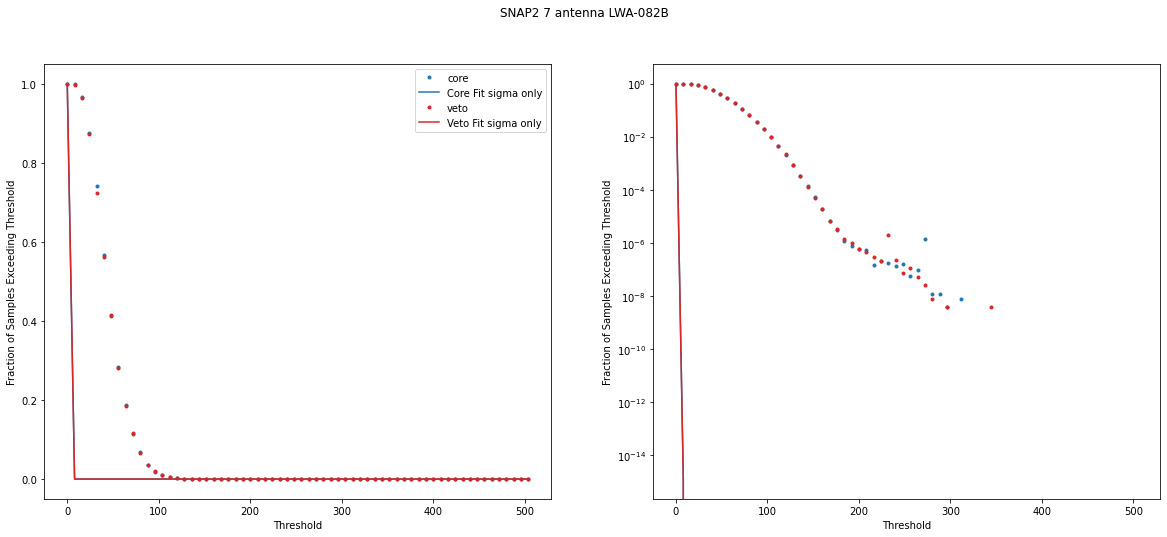

LWA-143A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


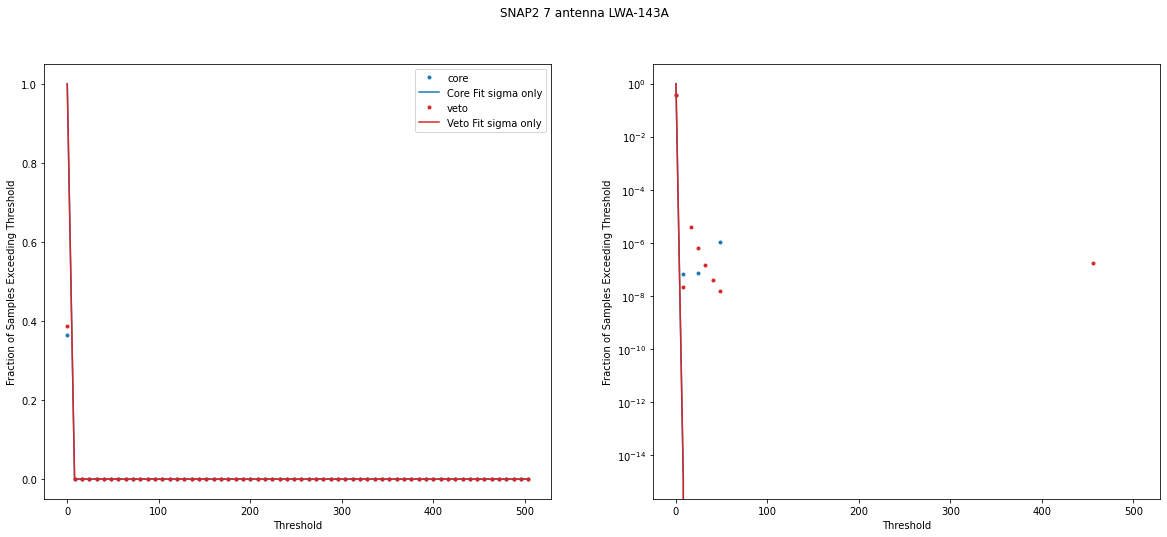

LWA-143B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


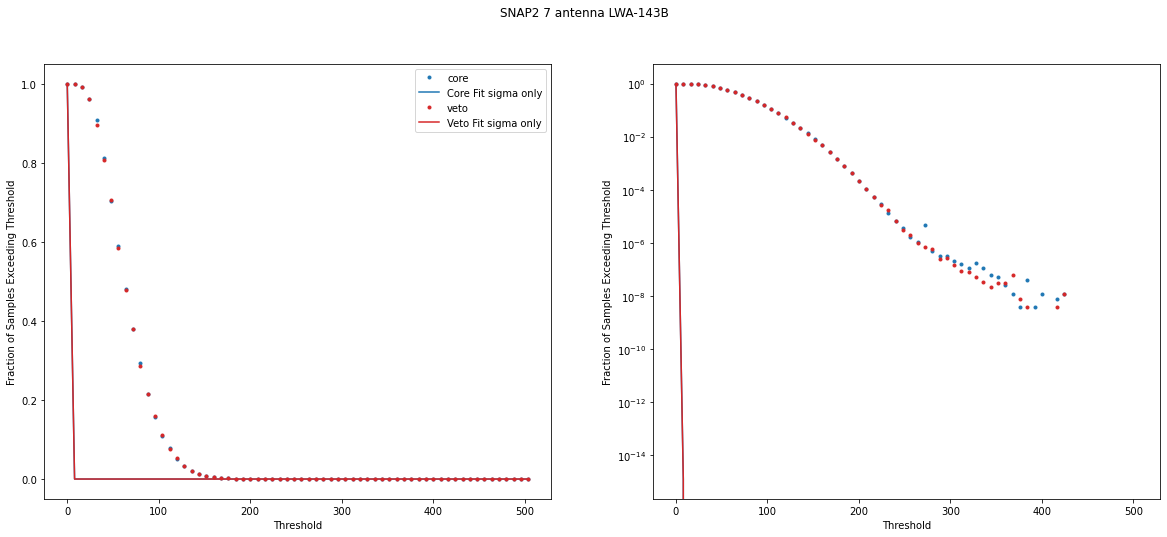

LWA-142A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


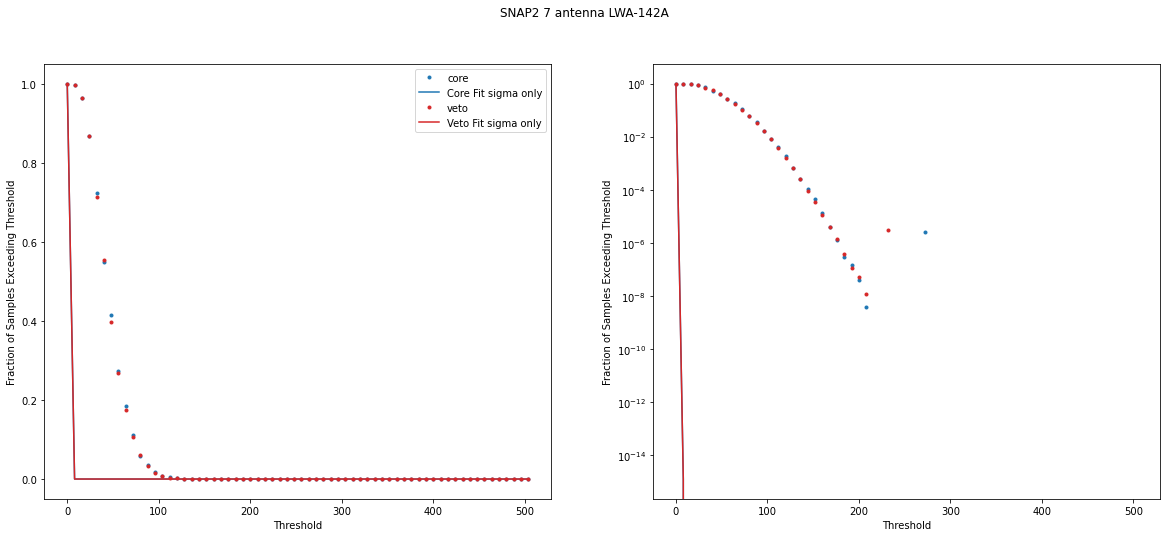

LWA-142B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


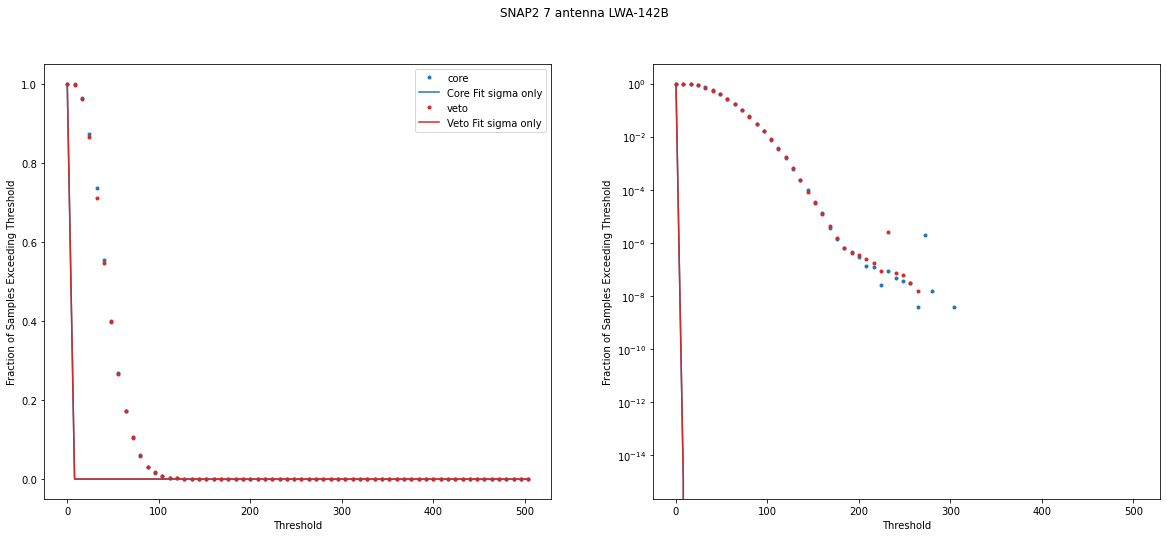

LWA-145A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


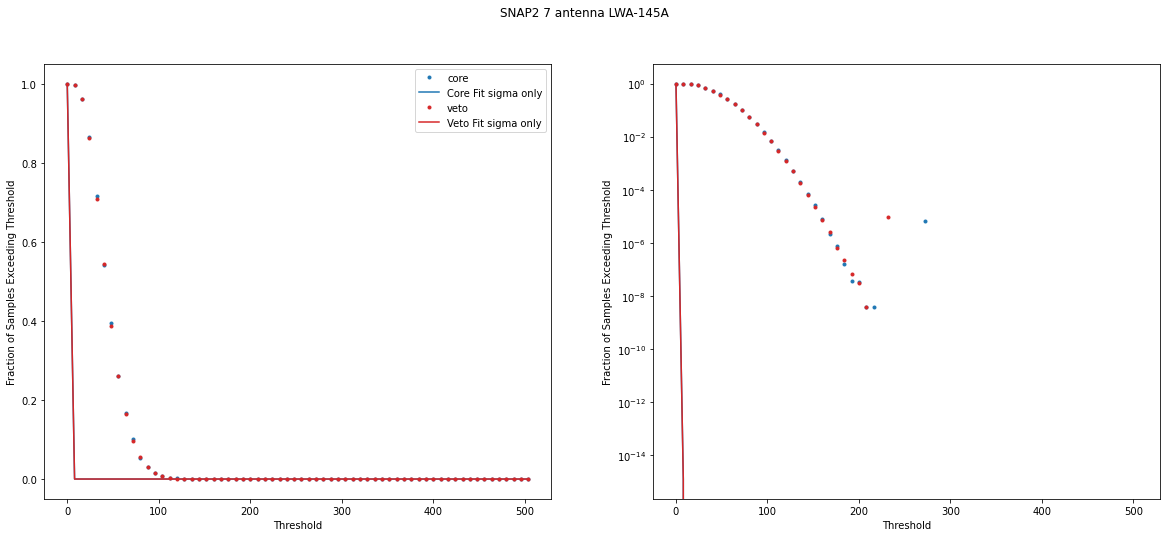

LWA-145B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


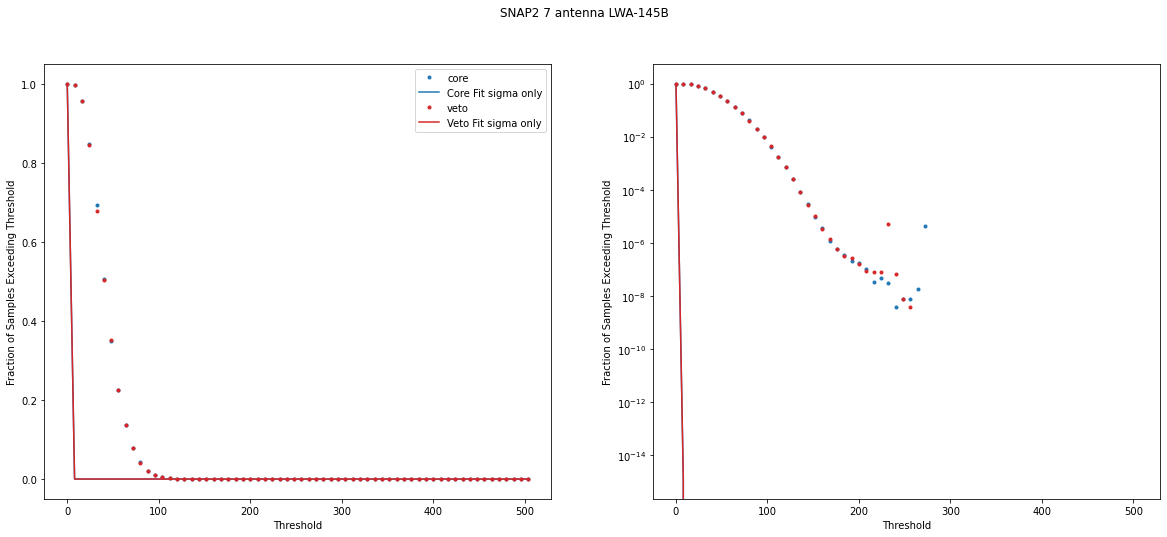

LWA-144A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


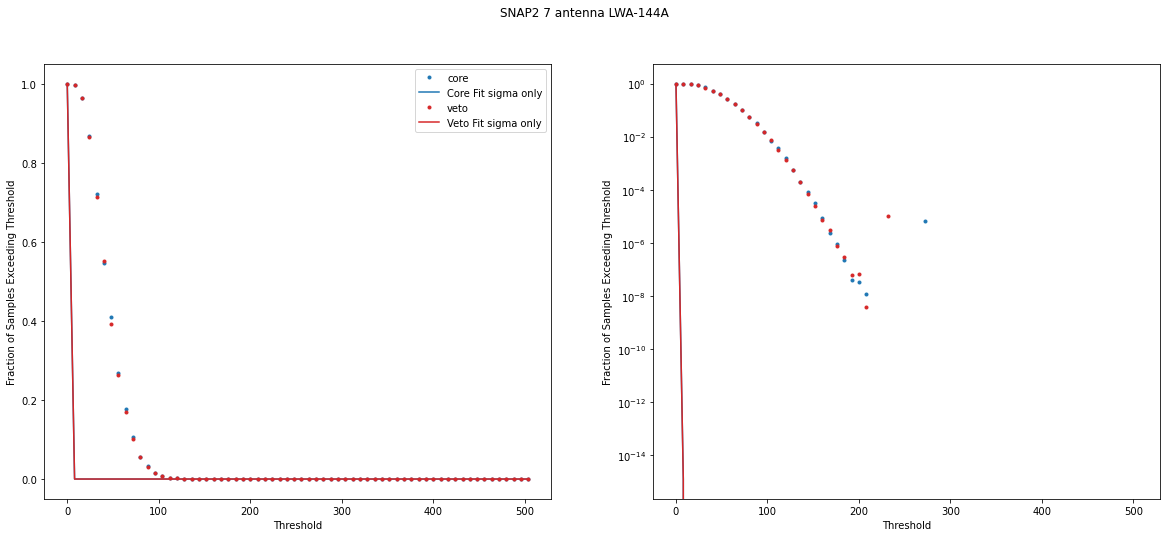

LWA-144B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


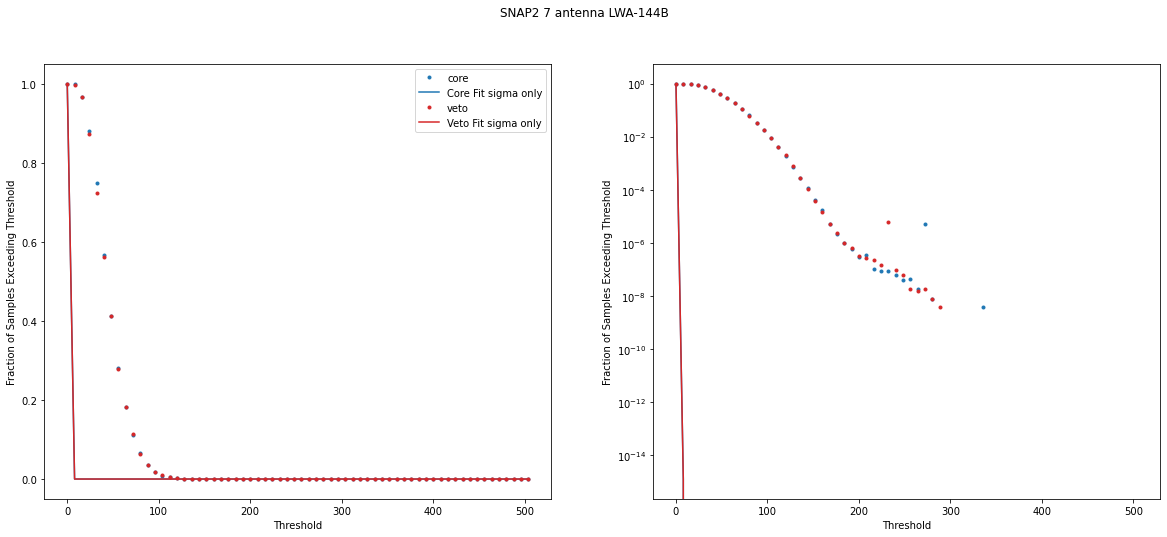

LWA-147A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


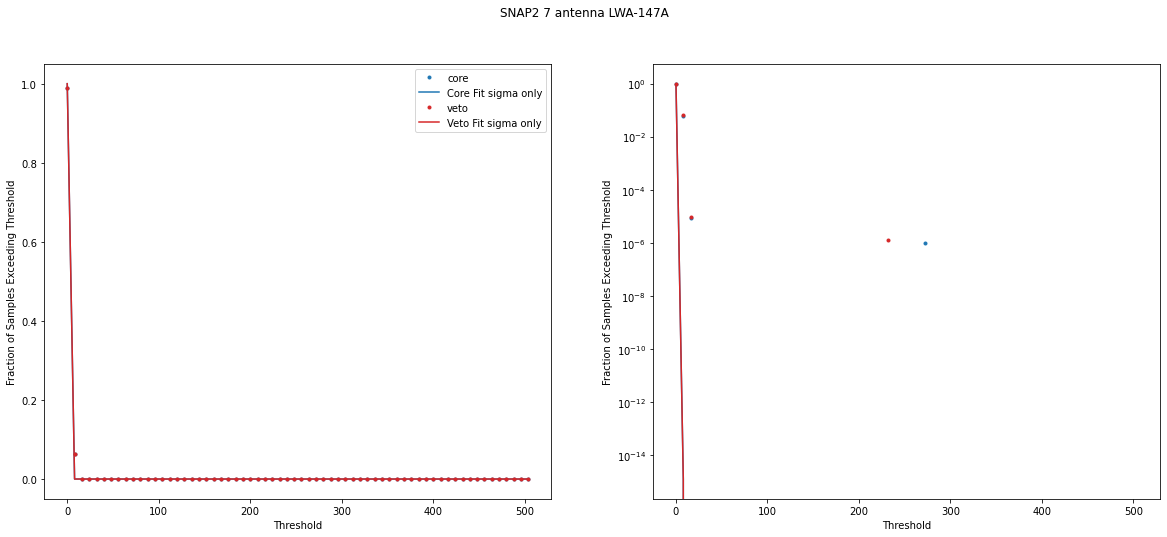

LWA-147B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


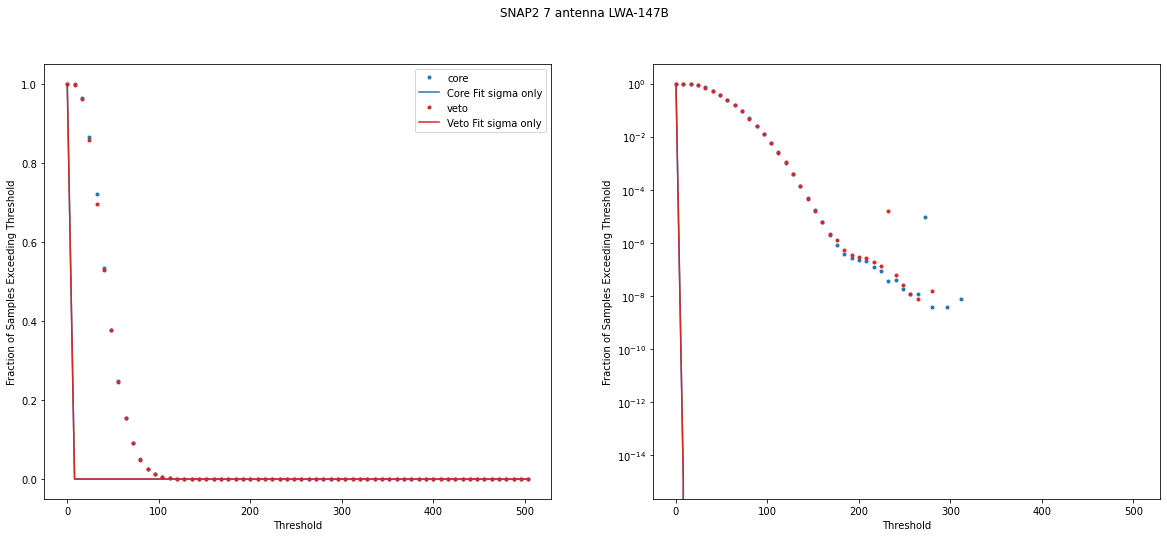

LWA-150A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


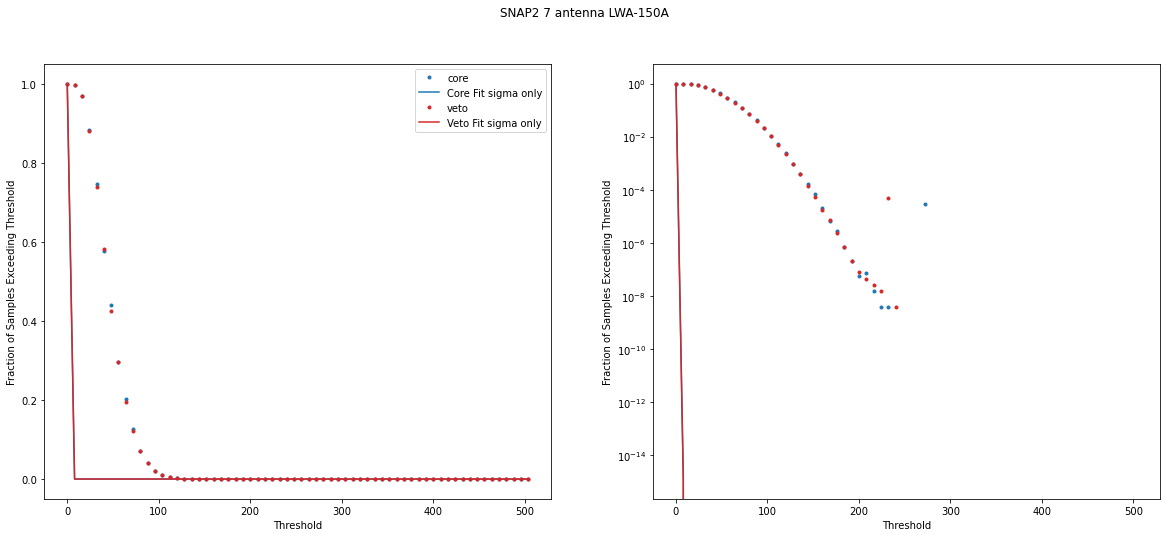

LWA-150B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


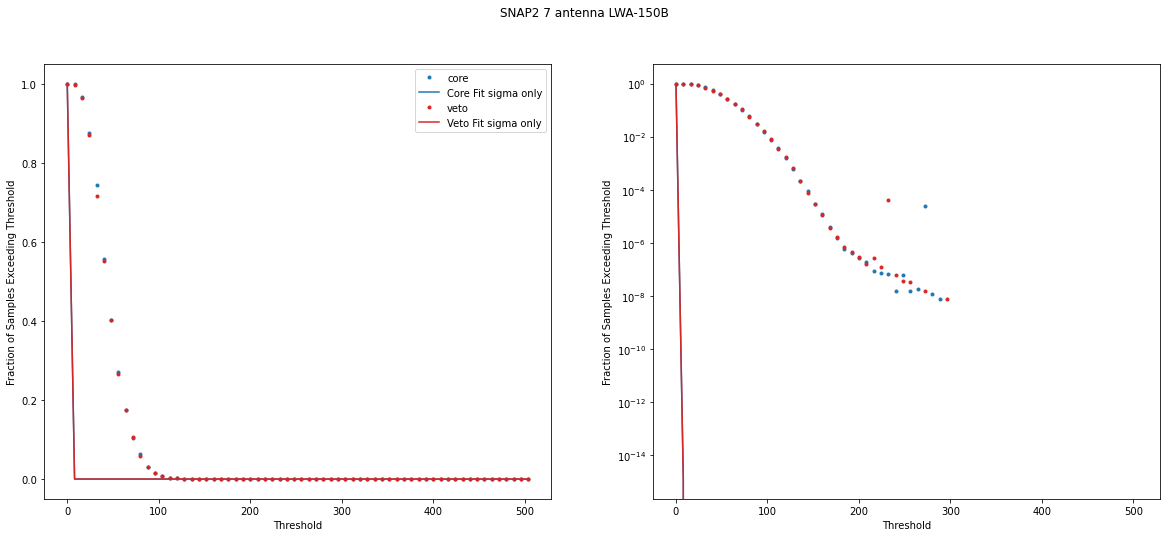

LWA-149A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


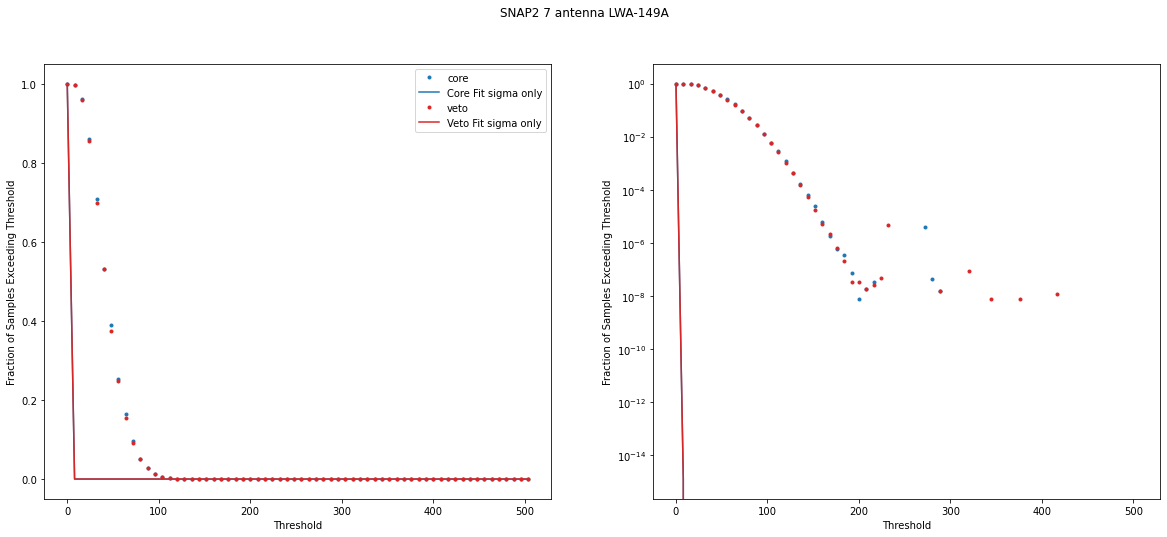

LWA-149B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


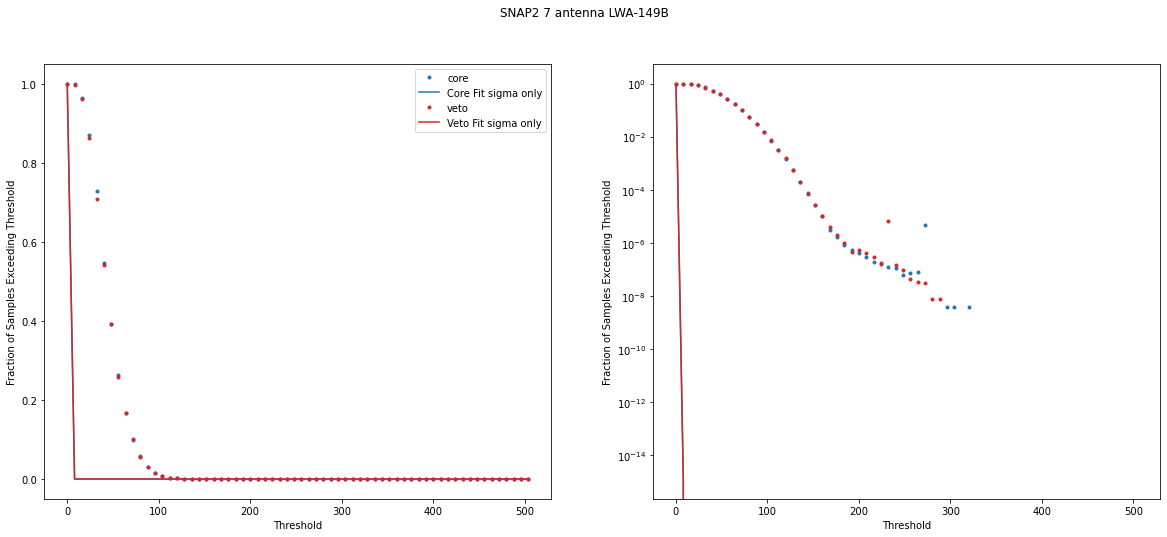

LWA-148A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


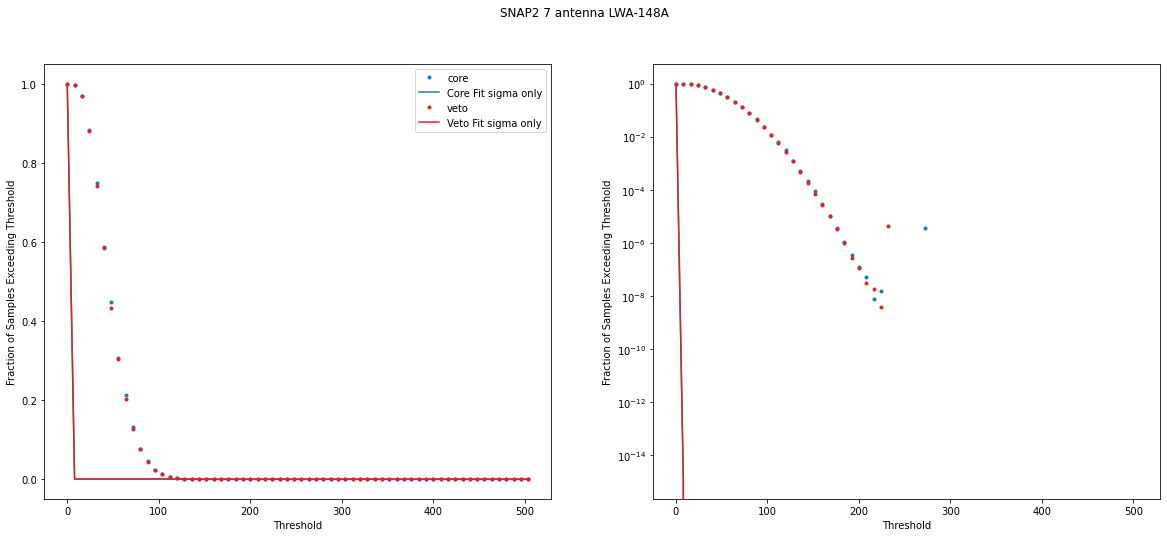

LWA-148B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


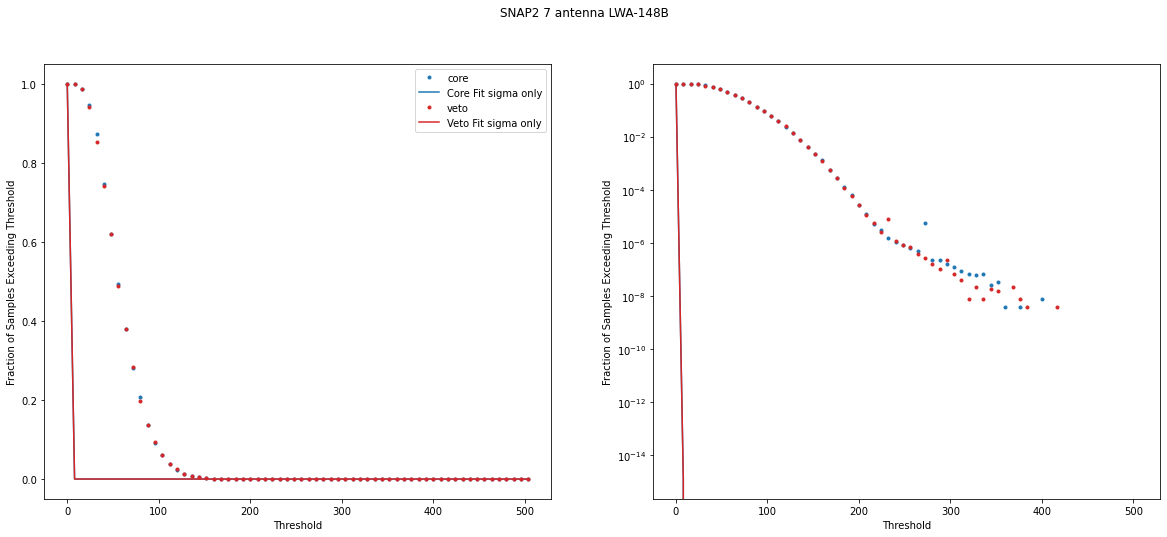

LWA-151A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


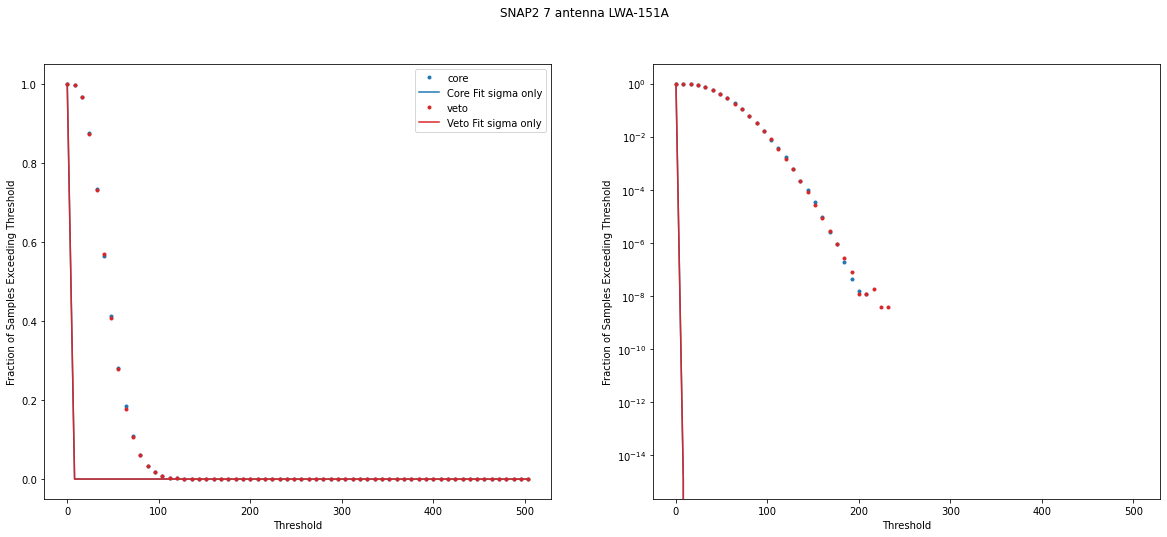

LWA-151B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


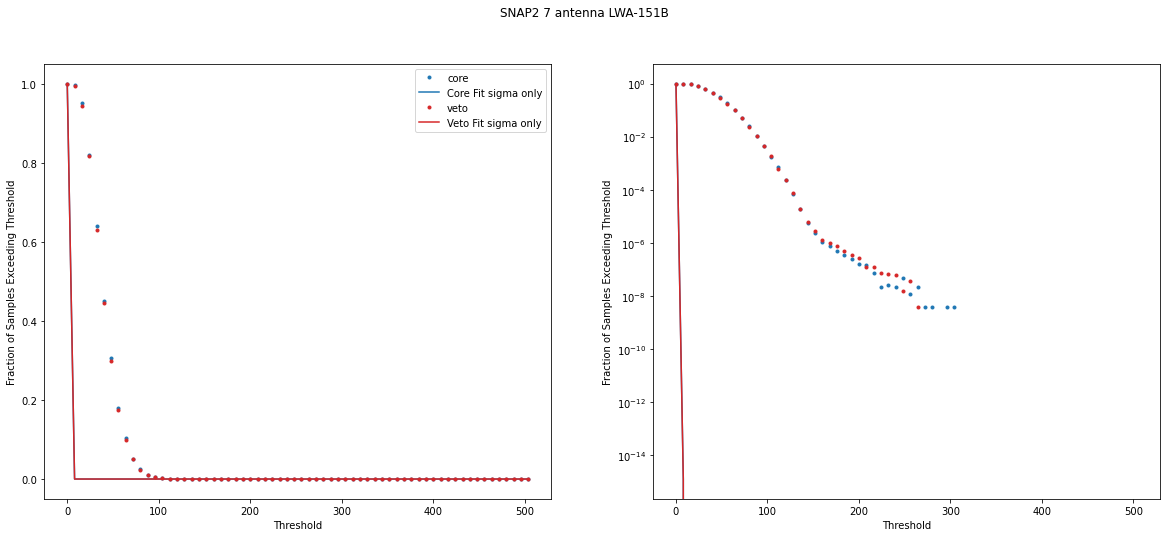

LWA-172A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


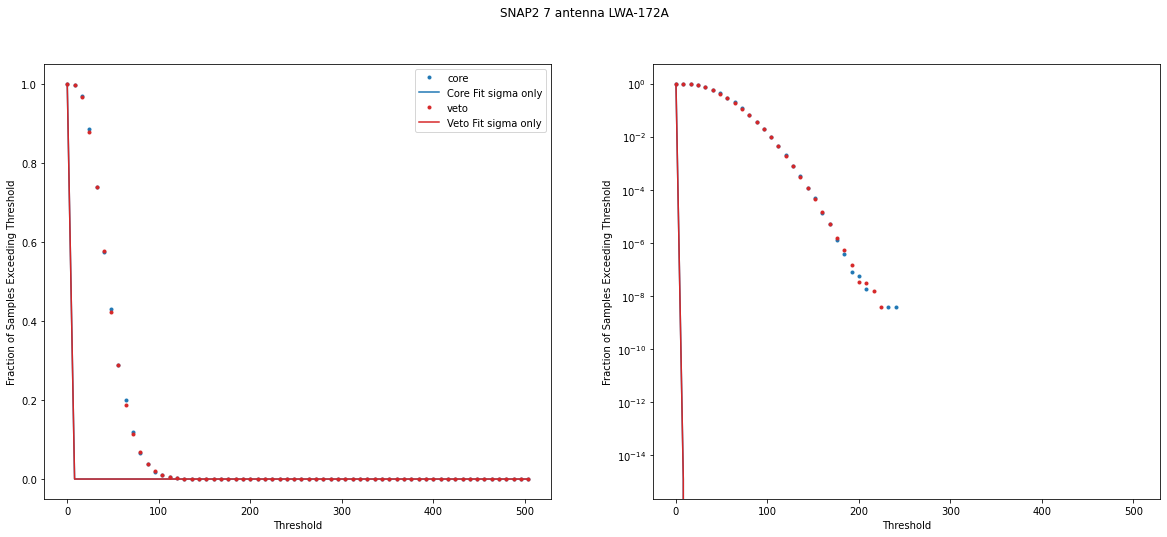

LWA-172B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


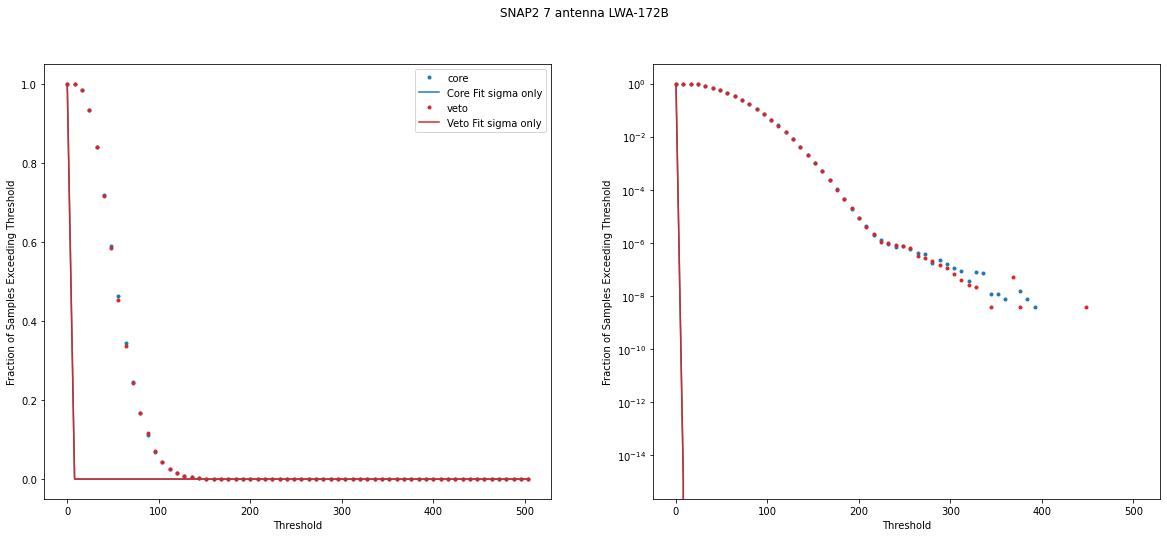

LWA-279A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


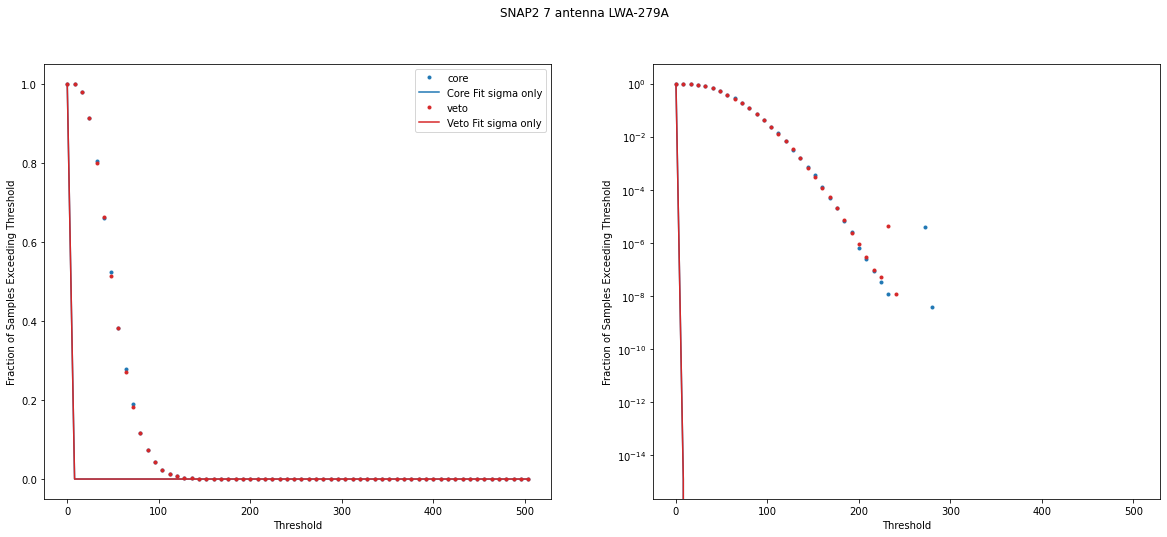

LWA-279B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


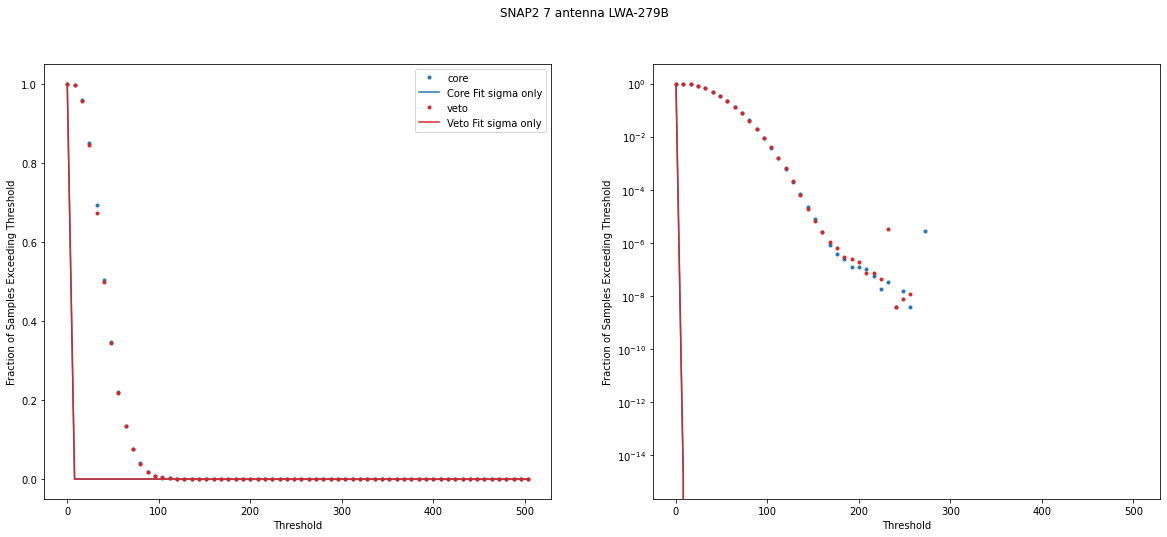

LWA-178A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


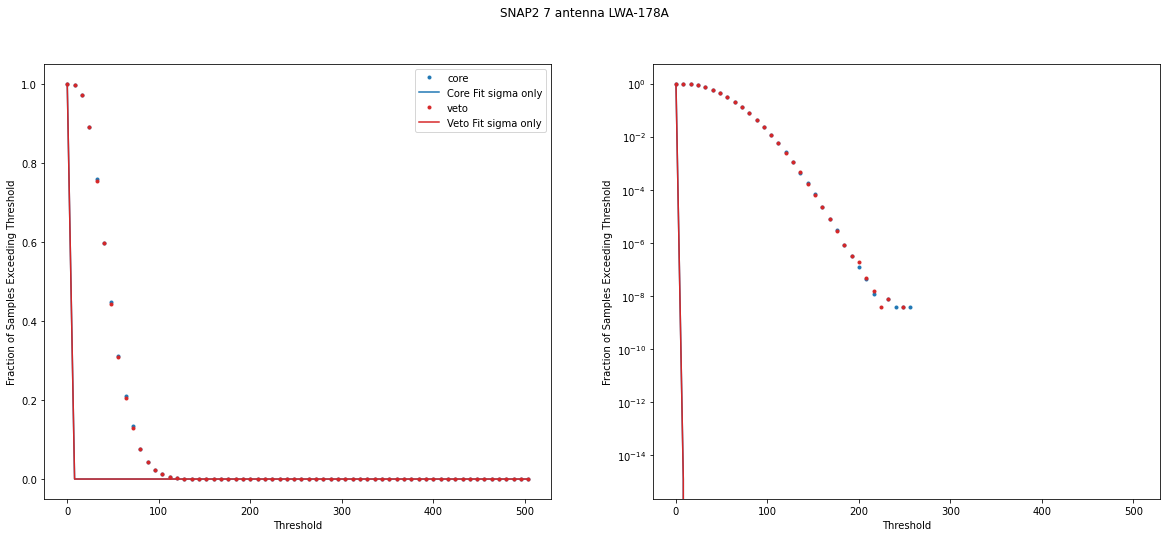

LWA-178B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


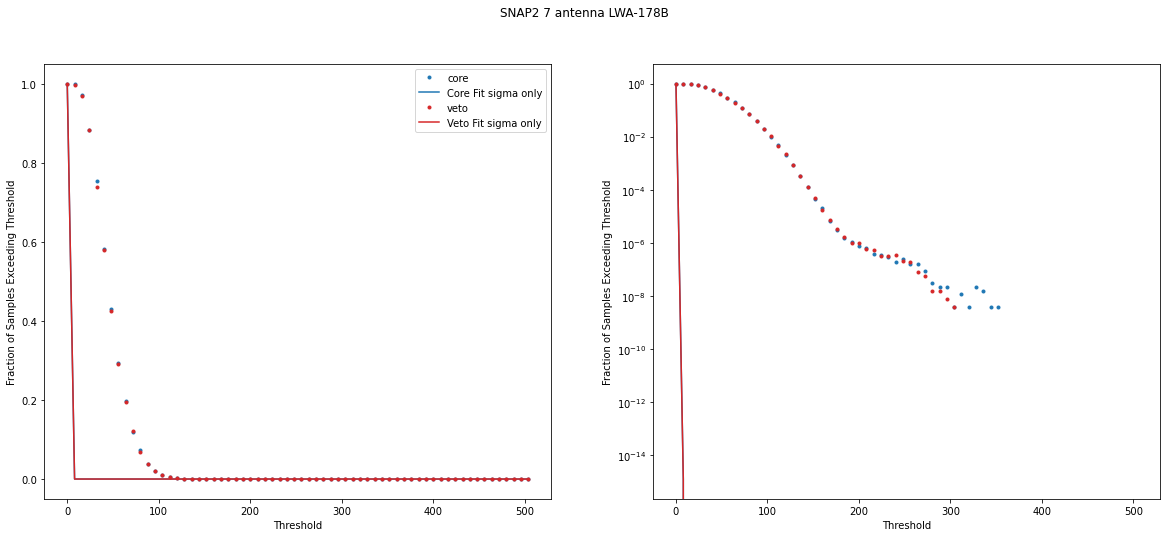

LWA-355A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


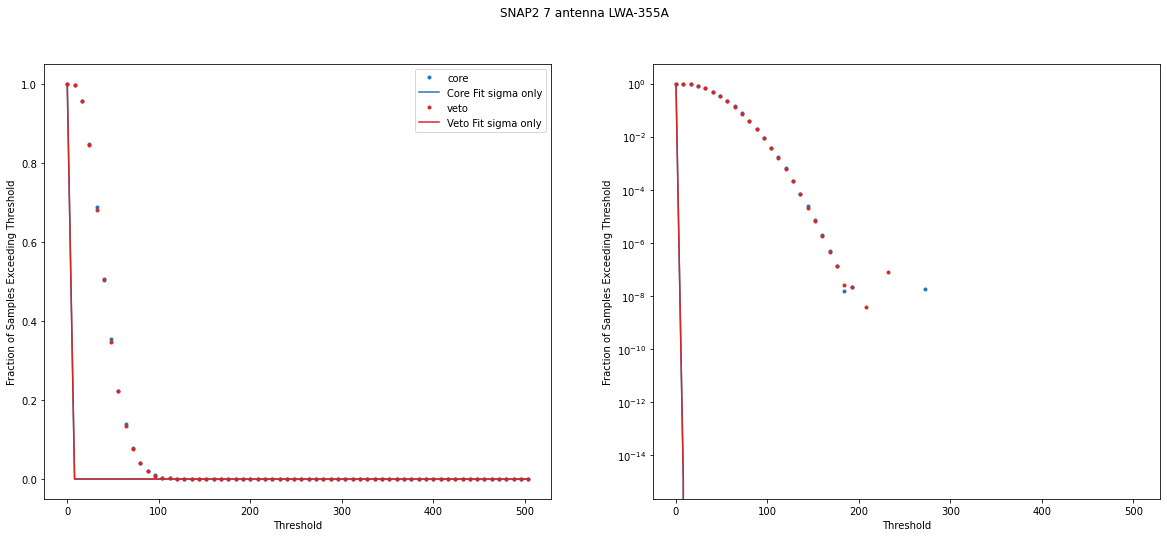

LWA-355B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


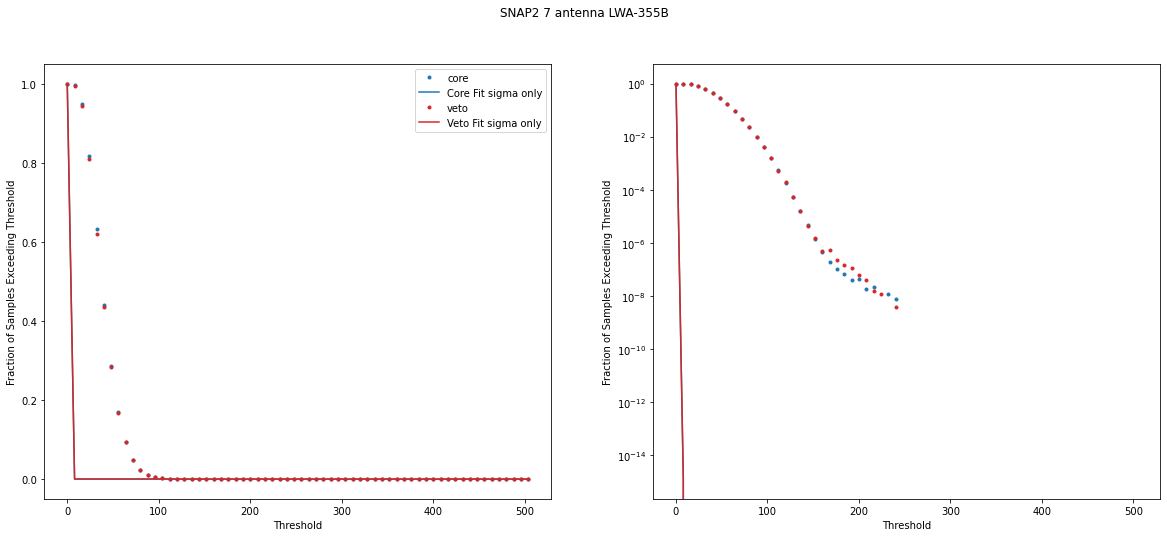

LWA-287A
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


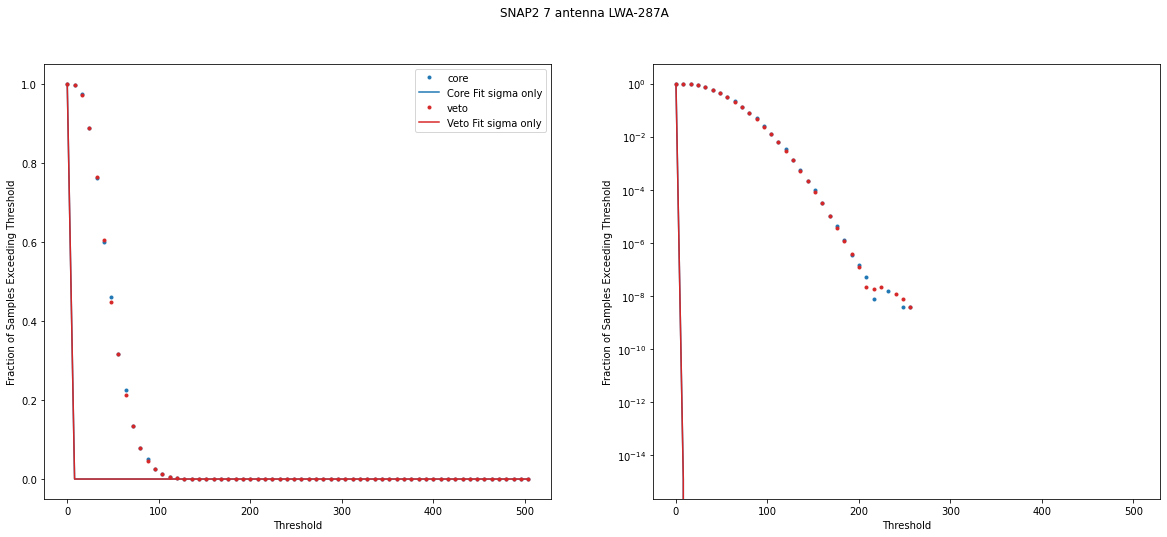

LWA-287B
Fit Core
[1.]
[[inf]]
Fit Veto
[1.]
[[inf]]


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


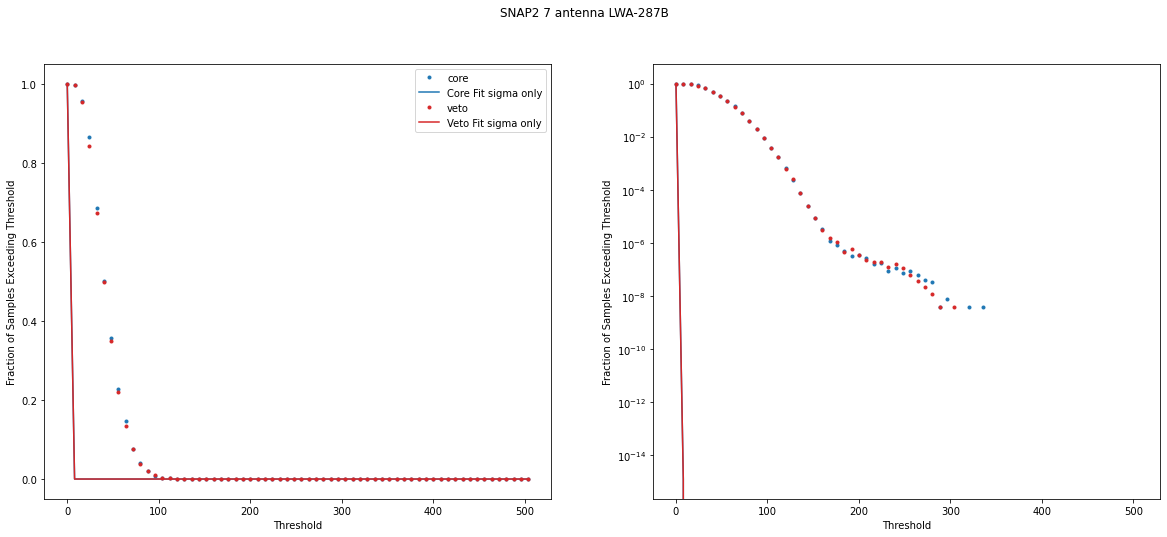

In [46]:

results_core=np.load(fnamec)
results_veto=np.load(fnamev)

def prob_simple(x,s):
    #fraction of samples whose absolute value iexceeds a threshold x if the sample is described by a Gaussian PDF with zero mean and variance s^2
    p = 1 - 0.5*(sp.erf((x)/((2**0.5)*s)) + sp.erf((x)/((2**0.5)*s)))
    return p

#snap051673764473.2053006results_c.npy

rate_core = results_core/(2**28 - 1)
rate_veto = results_veto/(2**28 - 1)

corefitsigmas = np.zeros((64,11))
corefitsigmaerrs = np.zeros((64,11))
vetofitsigmas = np.zeros((64,11))
vetofitsigmaerrs = np.zeros((64,11))

for b in [7]: #list boards to make the plot for. b is the one-indexed snap number (i.e. it can be 1-11 inclusive)
    plt.suptitle('SNAP2 '+str(b))
    for a in range(64):
        antname=mapping.snap2_to_antpol(b,a)
        print(antname)
        print("Fit Core")
        popt1,pcov1 = oz.curve_fit(prob_simple,thresholds,rate_core[a,:,b])
        corefitsigmas[a]=popt1[0]
        corefitsigmaerrs[a]=pcov1[0]
        print(popt1)
        print(pcov1)

        print("Fit Veto")
        popt2,pcov2 = oz.curve_fit(prob_simple,thresholds,np.flip(rate_veto[a,:,b]))
        vetofitsigmas[a]=popt2[0]
        vetofitsigmaerrs[a]=pcov2[0]
        print(popt2)
        print(pcov2)

        model1 = prob_simple(thresholds,popt1[0])
        model2 = prob_simple(thresholds,popt2[0])

        plt.figure(figsize=(20,8))
        plt.suptitle('SNAP2 '+str(b)+' antenna ' +antname)

        plt.subplot(121)
        plt.xlabel("Threshold")
        plt.ylabel("Fraction of Samples Exceeding Threshold")
        plt.plot(thresholds,rate_core[a,:,b],'C0.',label='core')
        plt.plot(thresholds,model1,'C0-',label="Core Fit sigma only")

        plt.plot(np.flip(thresholds),rate_veto[a,:,b],'C3.',label='veto')
        plt.plot(thresholds,model2,'C3-',label="Veto Fit sigma only")

        plt.legend()

        plt.subplot(122)
        plt.xlabel("Threshold")
        plt.ylabel("Fraction of Samples Exceeding Threshold")
        plt.semilogy(thresholds,rate_core[a,:,b],'C0.',label='core')
        plt.semilogy(thresholds,model1,'C0-',label="Core Fit sigma only")

        plt.semilogy(np.flip(thresholds),rate_veto[a,:,b],'C3.',label='veto')
        plt.semilogy(thresholds,model2,'C3-',label="Veto Fit sigma only")
        plt.show()

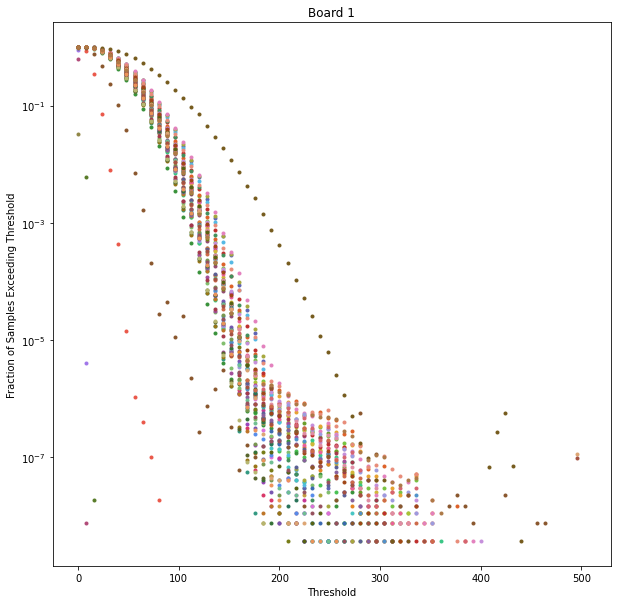

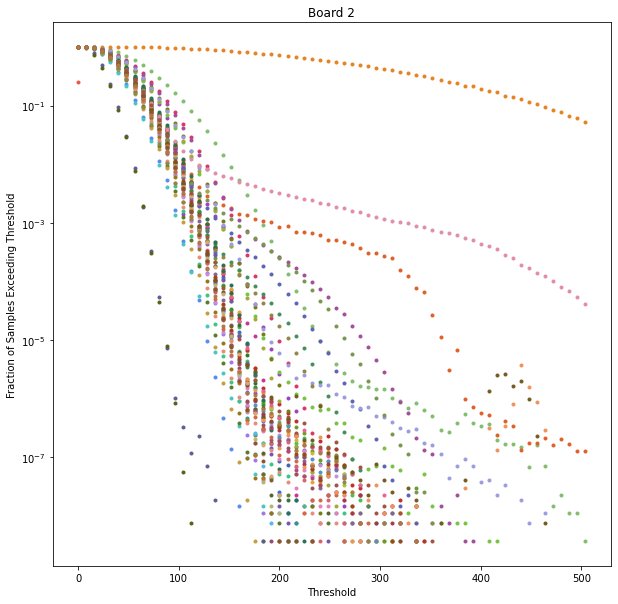

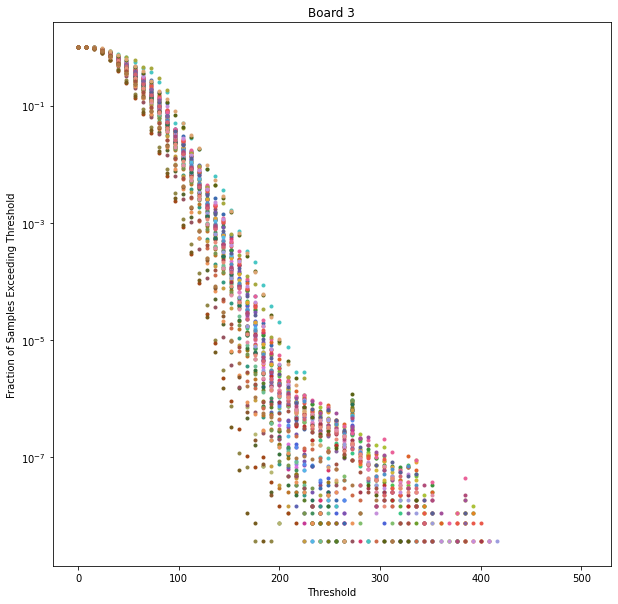

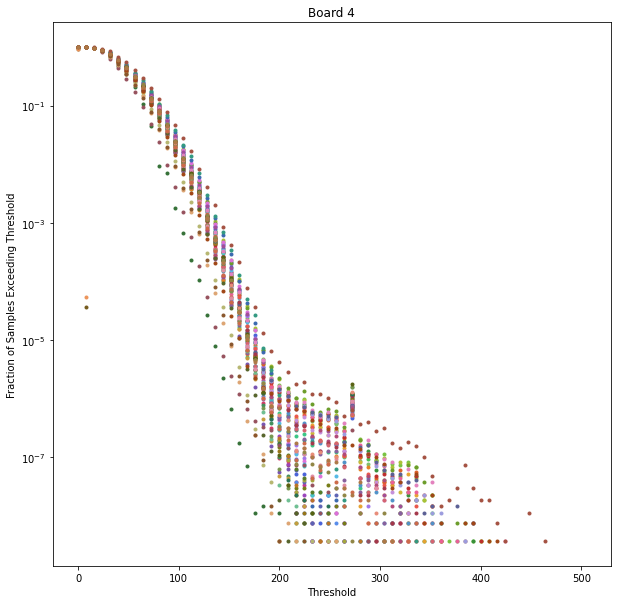

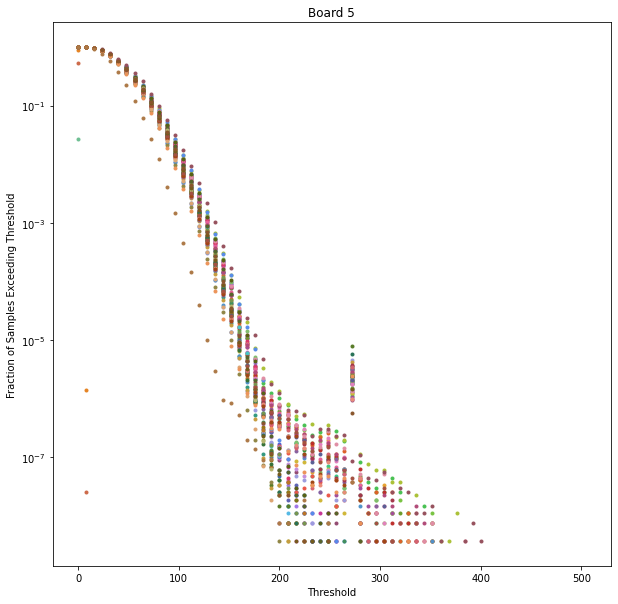

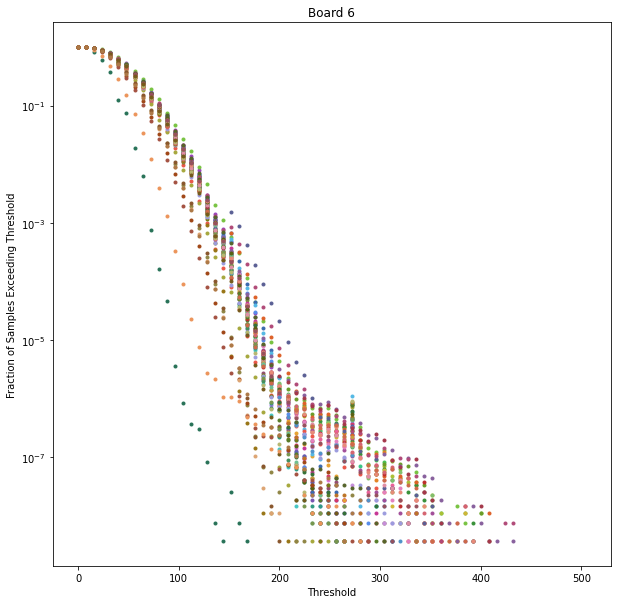

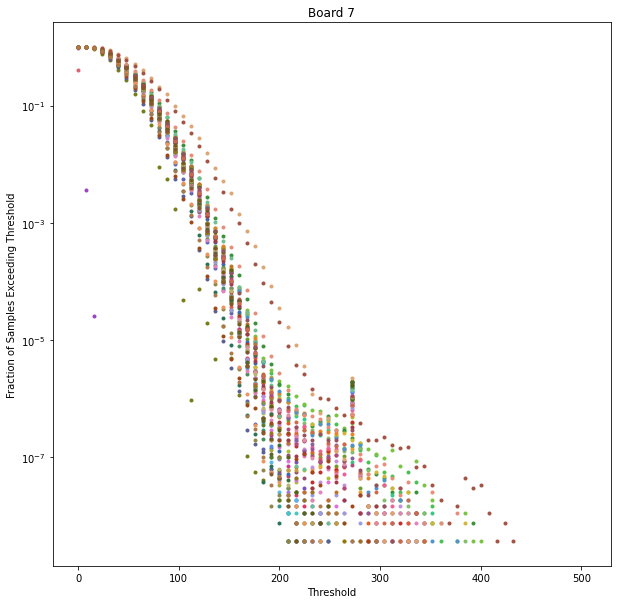

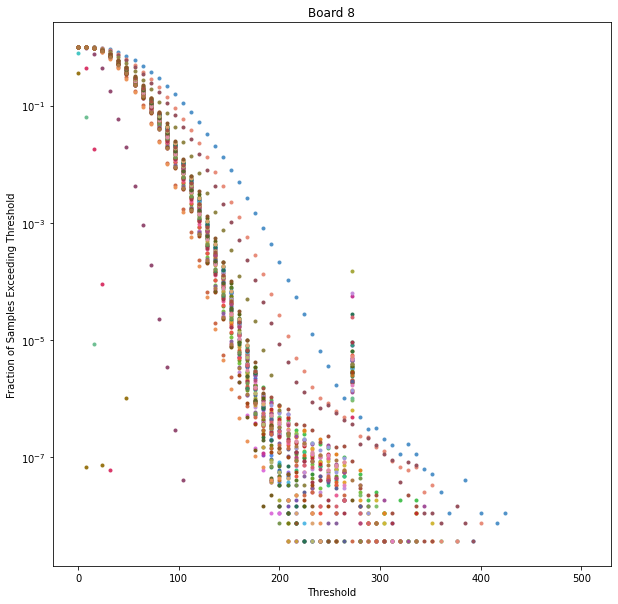

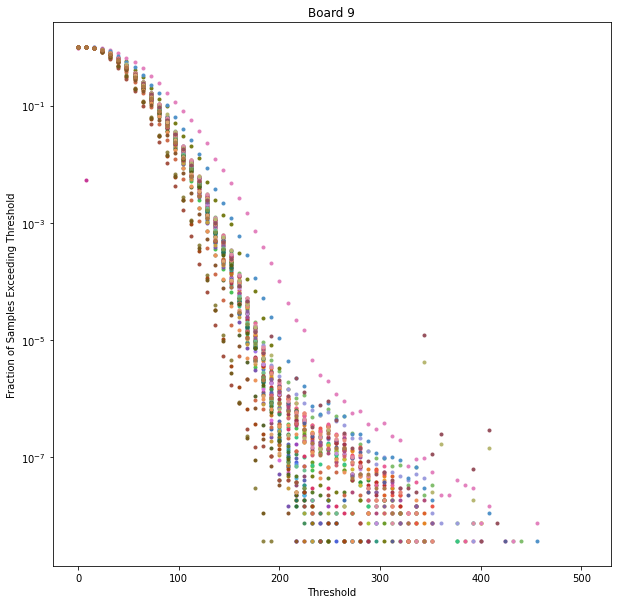

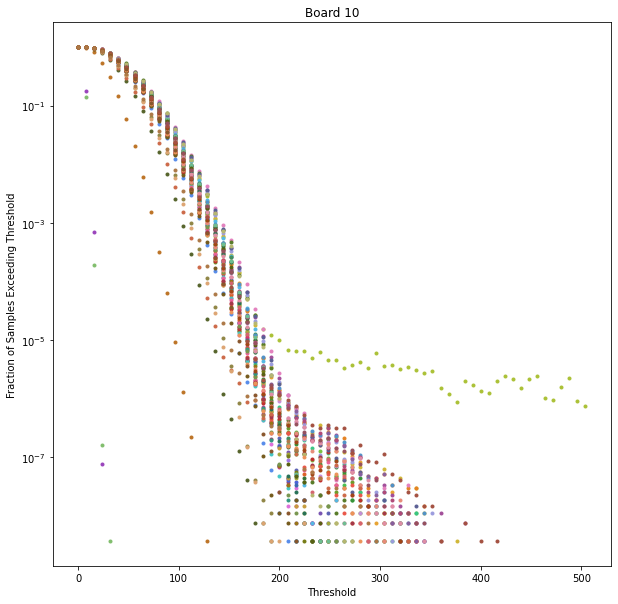

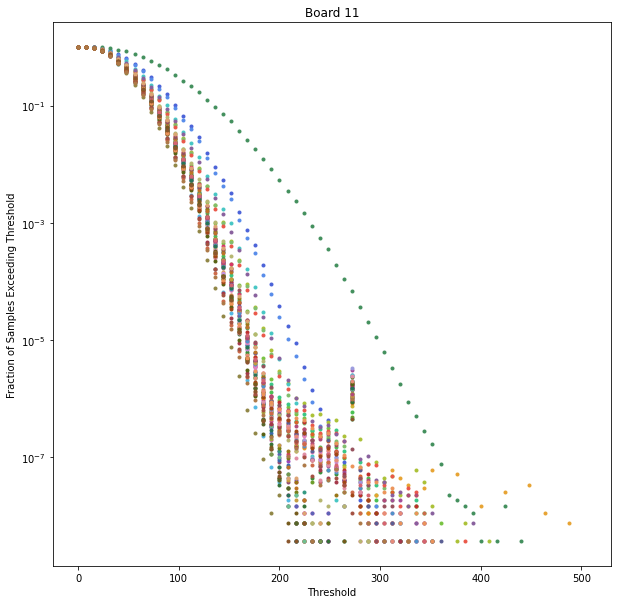

In [47]:

results_core=np.load(fnamec)
results_veto=np.load(fnamev)
rate_core = results_core/(2**28 - 1)
rate_veto = results_veto/(2**28 - 1)
thresholds = 8*np.asarray(range(64))
vthresholds = np.flip(thresholds)

colors = ["#934b71","#48c152","#9a44bc","#78c341","#4a62d8","#abc136","#a076e9","#6b9c29","#dd70db","#389139","#c63695","#39c685","#d93668","#81be6d","#7854b1","#d0b737","#578cea","#e7a332","#5d63b4","#e58323","#3a69af","#dd6128","#54b9e5","#be2e2c","#46c6c4","#ea5749","#329981","#ea6098","#428f5c","#a24e99","#a6a83d","#c58fdb","#767c16","#e381be","#587b28","#9c9cde","#987516","#5092c9","#bd7426","#5a5f94","#c69d3f","#88609d","#357137","#b14a78","#6ebf92","#a4384a","#277257","#d56470","#78964f","#e08ea5","#586113","#e88c79","#56642b","#cd6a49","#b7b771","#96515d","#908645","#a04616","#dda573","#a45141","#755a1c","#ec945a","#89562c","#ad7947"]
for b in range(11):
    plt.figure(figsize=(10,10))
    plt.title("Board "+str(b+1))
    for a in range(64):
        plt.semilogy(thresholds,rate_core[a,:,b],'.',color=colors[a],label=str(a))

    plt.xlabel("Threshold")
    plt.ylabel("Fraction of Samples Exceeding Threshold")
    #plt.legend()
    plt.show()


### How often are antennas saturating? -- harder to define here

In [48]:

'''# how often is saturation?
for b in range(11):
    plt.figure()
    plt.title("snap "+str(b+1))
    plt.hist(results_core[:,-1,b],80)
    plt.xlabel("Number of times smoothed filtered power > 508 adc units")
    plt.ylabel("Number of antennas")
    plt.show()

count=0
for b in range(11):
    for a in range(64):
        if results_core[a,-1,b]>1000:
            antname=mapping.snap2_to_antpol(b,a)
            print('antennas that saturated more than 1000 times',antname, ' snap ',b+1, results_core[a,-1,b])
            count+=1
print(count)

count=0
for b in range(11):
    for a in range(64):
        if results_core[a,-1,b]>100:
            antname=mapping.snap2_to_antpol(b,a)
            #print('antennas that saturated more than 100 times',antname, results_core[a,-1])
            count+=1
print(count)

count=0
for b in range(11):
    for a in range(64):
        if results_core[a,-1,b]>=1:
            antname=mapping.snap2_to_antpol(b,a)
            #print('antennas that saturated',antname, results_core[a,-1])
            count+=1   
print(count)
'''

'# how often is saturation?\nfor b in range(11):\n    plt.figure()\n    plt.title("snap "+str(b+1))\n    plt.hist(results_core[:,-1,b],80)\n    plt.xlabel("Number of times smoothed filtered power > 508 adc units")\n    plt.ylabel("Number of antennas")\n    plt.show()\n\ncount=0\nfor b in range(11):\n    for a in range(64):\n        if results_core[a,-1,b]>1000:\n            antname=mapping.snap2_to_antpol(b,a)\n            print(\'antennas that saturated more than 1000 times\',antname, \' snap \',b+1, results_core[a,-1,b])\n            count+=1\nprint(count)\n\ncount=0\nfor b in range(11):\n    for a in range(64):\n        if results_core[a,-1,b]>100:\n            antname=mapping.snap2_to_antpol(b,a)\n            #print(\'antennas that saturated more than 100 times\',antname, results_core[a,-1])\n            count+=1\nprint(count)\n\ncount=0\nfor b in range(11):\n    for a in range(64):\n        if results_core[a,-1,b]>=1:\n            antname=mapping.snap2_to_antpol(b,a)\n            

## Threshold scan for every board individually but in (approximately) parallel

In [49]:

#set up coincidencer
trigger_power_thresh=0 #will set later, in steps during scan
veto_power_thresh=0
trigger_window=int(round(1.96e8*100/3e8,1)) #number of clock cycles to travel 100 meters
veto_window=0
antenna_number_thresh=0 # will set later, in steps during scan
veto_number_thresh=0
core_roles_array=np.ones(64,dtype=int)
veto_roles_array=np.ones(64,dtype=int) #not using for now

[setup_coincidencer(casperbrd,trigger_power_thresh,
                          veto_power_thresh,
                          trigger_window,
                          veto_window,
                          antenna_number_thresh,
                          veto_number_thresh,
                          core_roles_array,
                          veto_roles_array) for casperbrd in casperbrds]

# define settings to loop through
voltage_thresh=np.asarray([100,125,150,175,200,225,250,300,350])
ant_number_thresh=np.asarray([4,5,7,10,15,20,30])
core_coincidences=np.zeros((len(voltage_thresh),len(ant_number_thresh),11))

for m in range(len(ant_number_thresh)):
    [setvalue(casperbrd,'antenna_number_thresh','cr_registers.xlsx',ant_number_thresh[m]) for casperbrd in casperbrds]
    for i in range(len(voltage_thresh)):
        t_c = voltage_thresh[i]
        [setvalue(casperbrd,"trigger_power_thresh","cr_registers.xlsx",int(t_c**2)) for casperbrd in casperbrds]
        time.sleep(2.75)  #have to wait for it to update
        for b, casperbrd in enumerate(casperbrds):
            veto_coincidence,core_coincidence=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_and_veto_rate",2*4,0))
            core_coincidences[i,m,b]=core_coincidence

In [50]:
np.save(fnameout,core_coincidences)

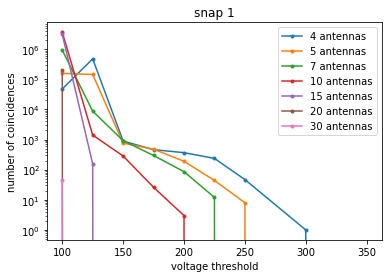

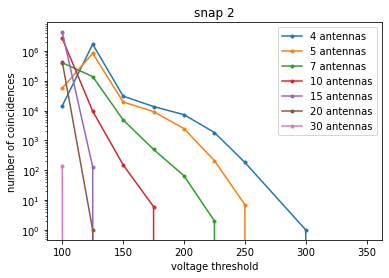

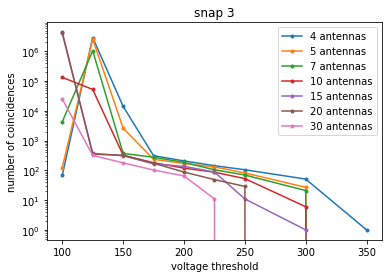

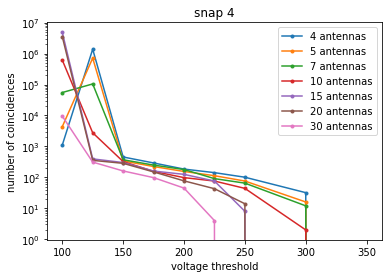

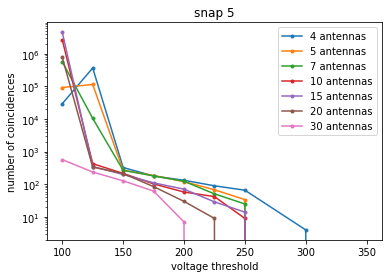

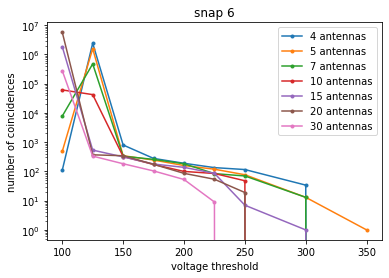

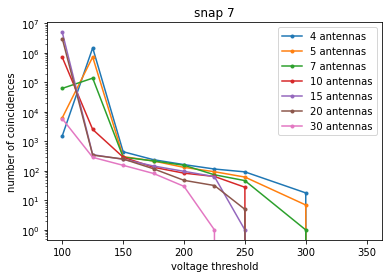

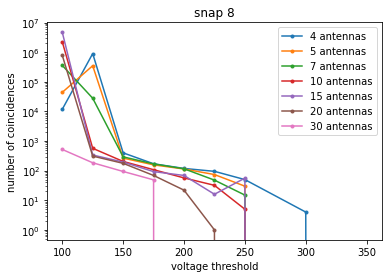

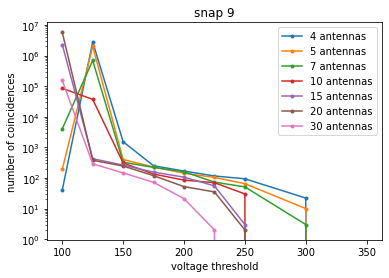

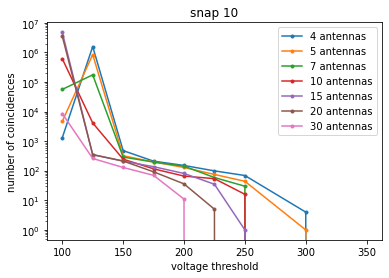

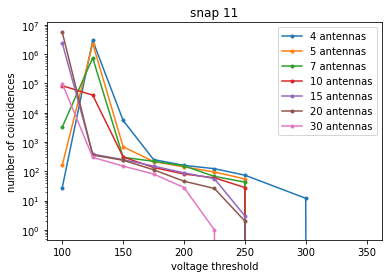

In [51]:
core_coincidences=np.load(fnameout)
for b in range(11):
    plt.figure()
    plt.title("snap "+str(b+1))

    for m in range(len(ant_number_thresh)):
        plt.semilogy(voltage_thresh,core_coincidences[:,m,b],'.-',label=str(ant_number_thresh[m])+ ' antennas')
    plt.legend()
    plt.xlabel('voltage threshold')
    plt.ylabel('number of coincidences')

This are plots of the number of events meeting the coincident trigger condition, for different voltage thresholds and antenna number thresholds. Note that no veto antennas were set and each measurement is done sequentially, in a dynamic RFI environment.

## Scan using veto antennas -- skipping on Feb 19-20 because so many lost power due to weather 

I have modified this to just monitor rates with core.

In [52]:
current_ok_vetos=np.load('/home/ubuntu/kp/ok_vetos-2024-2-20.npy')
current_ok_core=np.load('/home/ubuntu/kp/ok_core-2024-2-20.npy')
for p in range(11):
    veto_roles_array=current_ok_vetos[p,:]
    core_roles_array=current_ok_core[p,:]
    print(veto_roles_array)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0

In [53]:
[setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",0) for casperbrd in casperbrds]

brdnames=['snap01','snap02','snap03','snap04','snap05','snap06','snap07','snap08','snap09','snap10','snap11']
indices_of_good_snaps=[2,3,4,5,6,7,8,9,10]
ngoodsnaps=len(indices_of_good_snaps)
#set up coincidencer
current_ok_vetos=np.load('/home/ubuntu/kp/ok_vetos-2024-2-20.npy')
current_ok_core=np.load('/home/ubuntu/kp/ok_core-2024-2-20.npy')

trigger_power_thresh=200**2
veto_power_thresh=200**2
trigger_window=int(round(1.96e8*100/3e8,1)) #number of clock cycles to travel 100 meters
veto_window=int(round(1.96e8*2000/3e8,1)) #number of clock cycles to travel 2000 meters
antenna_number_thresh=7 
veto_number_thresh=0 # will set later, in steps during scan

for p in indices_of_good_snaps:
    veto_roles_array=current_ok_vetos[p,:]
    core_roles_array=current_ok_core[p,:]
    #core_roles_array=np.ones(current_ok_core[p,:].shape) #TEST TURN ALL ANTENNAS ON

    casperbrd=casperbrds[p]

    setup_coincidencer(casperbrd,trigger_power_thresh,
                          veto_power_thresh,
                          trigger_window,
                          veto_window,
                          antenna_number_thresh,
                          veto_number_thresh,
                          core_roles_array,
                          veto_roles_array)
    setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",1)

#veto_number_thresholds=[1,63,2,63,3,63,4,63]
veto_number_thresholds=[63,63,63,63,63,63,63,63] #KEEP THE VETO OFF BECAUSE SO MANY ARE DOWN

snapshots_per_second=np.zeros((len(veto_number_thresholds),11))
core_triggers=np.zeros((len(veto_number_thresholds),11))
veto_triggers=np.zeros((len(veto_number_thresholds),11))
core_cycles=np.zeros((len(veto_number_thresholds),11))
veto_cycles=np.zeros((len(veto_number_thresholds),11))
successful_triggers=np.zeros((len(veto_number_thresholds),11))
readout_dones=np.zeros((len(veto_number_thresholds),11))

for i, n in enumerate(veto_number_thresholds):
    [setvalue(casperbrd,"veto_number_thresh","cr_registers.xlsx",n) for casperbrd in casperbrds]
    time.sleep(2.75)  #wait to update

    for p in range(11): 
        casperbrd=casperbrds[p]
        veto_coincidence,core_coincidence=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_and_veto_rate",2*4,0))
        veto_total_cycles,core_total_cycles=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_n_veto_tot_clk_cycles",2*4,0))
        readout_done,successful_trigger=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_n_veto_tot_clk_cycles1",2*4,0))

        core_cycles[i,p]=core_total_cycles
        veto_cycles[i,p]=veto_total_cycles
        core_triggers[i,p]=core_coincidence                  
        veto_triggers[i,p]=veto_coincidence 
        readout_dones[i,p]=readout_done
        successful_triggers[i,p]=successful_trigger
        #print(p,n,core_coincidence,veto_coincidence,core_total_cycles,veto_total_cycles)


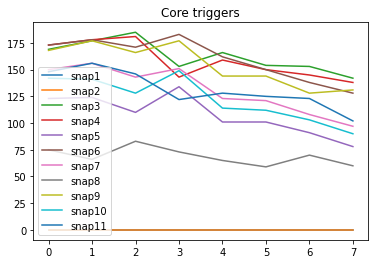

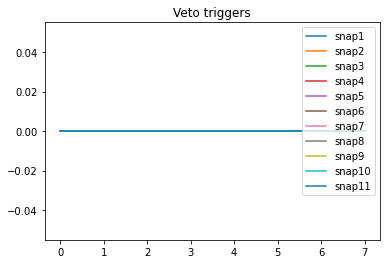

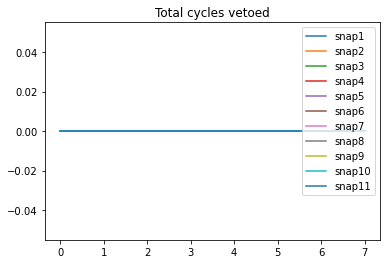

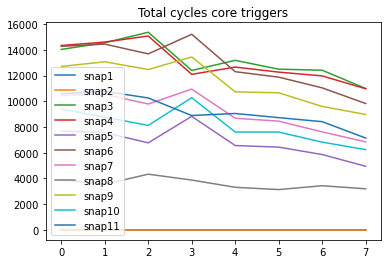

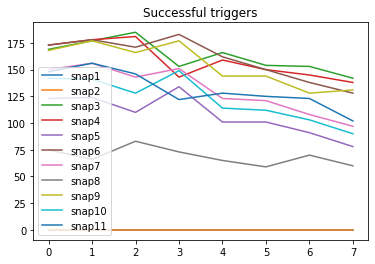

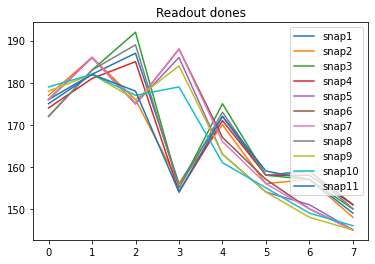

In [54]:
plt.figure()
for i in range(11):
    plt.title('Core triggers')  #note core is ALL antennas
    plt.plot(core_triggers[:,i],label='snap'+str(i+1))
plt.legend()

plt.figure()
for i in range(11):
    plt.title('Veto triggers')
    plt.plot(veto_triggers[:,i],label='snap'+str(i+1))
plt.legend()

plt.figure()
for i in range(11):
    plt.title('Total cycles vetoed')
    plt.plot(veto_cycles[:,i],label='snap'+str(i+1))
plt.legend()
    
plt.figure()
for i in range(11):
    plt.title('Total cycles core triggers')
    plt.plot(core_cycles[:,i],label='snap'+str(i+1))
plt.legend()

plt.figure()
for i in range(11):
    plt.title('Successful triggers')
    plt.plot(successful_triggers[:,i],label='snap'+str(i+1))
plt.legend()

plt.figure()
for i in range(11):
    plt.title('Readout dones')
    plt.plot(readout_dones[:,i],label='snap'+str(i+1))
plt.legend()

### Completely reset trigger on all boards. It's good to run this at the end before running something else to configure the trigger for observing.

In [39]:
## COmpletely reset trigger on all boards
veto_roles_array=np.zeros(64,dtype=int)
core_roles_array=np.zeros(64,dtype=int)
for p in range(11):
    casperbrd=casperbrds[p]
    setup_coincidencer(casperbrd,0,
                          0,
                          0,
                          0,
                          0,
                          0,
                          core_roles_array,
                          veto_roles_array)
    setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",0)
